Draft Code to get the number of quarter turns and the time spent aroud a tower for each visit (from first to last QT before leaving the tower)

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter as smooth
from matplotlib.patches import Polygon
from typing import Any
plt.style.use('./paper.mplstyle')
import gc
import glob
import time
from behavior_analysis_functions import list_sessions_analyzed, \
                                    process_session, html_mouse, load_data, MOUSE_STRING


In [5]:
#define the coordinates of each patch
RESOLUTION = 512, 512
TRAPEZE_SIZE = 35 #how much to extend outside of the objects to detect the trajectories
TRUE_SIGMA = 1 # For smoothing X y Positions

def trapezes_from_patch(patch, width):
    """
    generate the trapezes coordinates surrounding a patch
    inputs:
    patch - coordinates of a patch [[Xa, Ya], [Xb, Yb], [Xc, Yc], [Xd, Yd]]
    width - width of the trapeze in pixels
    outputs:
    coordinates [[Xa, Ya], [Xb, Yb], [Xc, Yc], [Xd, Yd]] for the 4 trapezes.
    
    trapezes_from_patch(SWpatch_coords, 200)
    """

    N = [patch[0], patch[1], [patch[1][0]+width, patch[1][1]+width], [patch[0][0]-width, patch[0][1]+width]]
    E = [patch[1], patch[2], [patch[2][0]+width, patch[2][1]-width], [patch[1][0]+width, patch[1][1]+width]]
    S = [patch[2], patch[3], [patch[3][0]-width, patch[3][1]-width], [patch[2][0]+width, patch[2][1]-width]]
    W = [patch[3], patch[0], [patch[0][0]-width, patch[0][1]+width], [patch[3][0]-width, patch[3][1]-width]]
    return N, E, S, W


NWpatch_coords = [[104, RESOLUTION[1] -  125], [173, RESOLUTION[1] -  125], [173, RESOLUTION[1] -  201], [104, RESOLUTION[1] -  201]]
NEpatch_coords = [[330, RESOLUTION[1] -  120], [400, RESOLUTION[1] -  120], [400, RESOLUTION[1] -  200], [330, RESOLUTION[1] -  200]]
SWpatch_coords = [[109, RESOLUTION[1] -  351], [181, RESOLUTION[1] -  351], [181, RESOLUTION[1] -  410], [109, RESOLUTION[1] -  410]]
SEpatch_coords = [[330, RESOLUTION[1] -  350], [400, RESOLUTION[1] -  350], [400, RESOLUTION[1] -  410], [330, RESOLUTION[1] -  410]]

collection_trapeze = {"NW":dict(), "NE":dict(), "SW":dict(), "SE":dict()}
collection_trapeze["NW"]["N"], collection_trapeze["NW"]["E"], collection_trapeze["NW"]["S"], collection_trapeze["NW"]["W"] = trapezes_from_patch(NWpatch_coords, TRAPEZE_SIZE)
collection_trapeze["NE"]["N"], collection_trapeze["NE"]["E"], collection_trapeze["NE"]["S"], collection_trapeze["NE"]["W"] = trapezes_from_patch(NEpatch_coords, TRAPEZE_SIZE)
collection_trapeze["SW"]["N"], collection_trapeze["SW"]["E"], collection_trapeze["SW"]["S"], collection_trapeze["SW"]["W"] = trapezes_from_patch(SWpatch_coords, TRAPEZE_SIZE)
collection_trapeze["SE"]["N"], collection_trapeze["SE"]["E"], collection_trapeze["SE"]["S"], collection_trapeze["SE"]["W"] = trapezes_from_patch(SEpatch_coords, TRAPEZE_SIZE)



In [18]:
path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/'
mouse="MOU2334"
session_list=['MOU2334_20240614-1015']
session_folder: str = path_to_data_folder  + mouse + os.sep + session_list[0]
print(session_folder)

mouse_folder = os.path.dirname(session_folder)


/Users/davidrobbe/Documents/Science/Data/ForagingMice/MOU2334/MOU2334_20240614-1015


In [28]:
path_to_data_folder = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/'
mouse="MOU4175"
session_list=['MOU4175_20230712-1809']
session_folder: str = path_to_data_folder  + mouse + os.sep + session_list[0]
print(session_folder)

mouse_folder = os.path.dirname(session_folder)


/Users/davidrobbe/Documents/Science/Data/ForagingMice/MOU4175/MOU4175_20230712-1809


In [25]:
mouse_folder
session_list[0]

'MOU4175_20230712-1809'

In [29]:
traj_df, turns_df, param_df=load_data(mouse_folder,session_list[0])

In [27]:
turns_df


time  framenumber  xposition  yposition currentPatch previousTrapeze  \
12    15.354          336        104        405           SW               S   
13    16.593          367         99        335           SW               W   
14    18.838          422        100        201           NW               S   
15    20.158          455         95        115           NW               W   
16    21.598          491        191        112           NW               N   
..       ...          ...        ...        ...          ...             ...   
509  714.328        17797        315        212           NE               S   
510  715.605        17829        325        107           NE               W   
511  716.687        17856        415        114           NE               N   
512  718.449        17900        407        216           NE               E   
513  719.650        17930        310        333           SE               N   

    currentTrapeze  turnDirection ongoingRewardedObject  \
12               W          270.0                ['SW']   
13               N          270.0                ['SW']   
14               W          270.0                ['NW']   
15               N          270.0                ['NW']   
16               E          270.0                ['NW']   
..             ...            ...                   ...   
509              W          270.0                ['NE']   
510              N          270.0                ['NE']   
511              E          270.0                ['NE']   
512              S          270.0                ['NE']   
513              W           90.0                ['SE']   

    ongoingRewardedDirection  Rewarded  nberOfConsecRewards  \
12                     [270]      True                    2   
13                     [270]      True                    3   
14                     [270]      True                    1   
15                     [270]      True                    2   
16                     [270]      True                    3   
..                       ...       ...                  ...   
509                    [270]      True                    3   
510                    [270]      True                    4   
511                    [270]      True                    5   
512                    [270]      True                    6   
513                    [270]     False                    0   

     maxNberOfConsecRewards typeOfTurn  totalnberOfRewards  
12                       12       gogd                   7  
13                       12       gogd                   8  
14                        9       gogd                   9  
15                        9       gogd                  10  
16                        9       gogd                  11  
..                      ...        ...                 ...  
509                       6       gogd                 307  
510                       6       gogd                 308  
511                       6       gogd                 309  
512                       6       gogd                 310  
513                       7       gobd                 310  

[502 rows x 15 columns]

In [17]:
traj_df.info

<bound method DataFrame.info of           time  xposition  yposition
327     15.034      149.0      421.0
328     15.076      144.0      422.0
329     15.115      138.0      422.0
330     15.156      132.0      421.0
331     15.195      124.0      420.0
...        ...        ...        ...
17934  719.851      303.0      353.0
17935  719.890      302.0      354.0
17936  719.930      302.0      353.0
17937  719.970      302.0      353.0
17938  720.010      302.0      353.0

[17612 rows x 3 columns]>

In [33]:
# Unpack the data
time = traj_df['time'].to_numpy()
xposition = traj_df['xposition'].to_numpy()
yposition = traj_df['yposition'].to_numpy()
yposition = RESOLUTION[1] - yposition # yposition is inverted, puts it back in the right way
xgauss = smooth(xposition, TRUE_SIGMA)
ygauss = smooth(yposition, TRUE_SIGMA) # Smoothes the positions with true sigma

In [30]:
import pickle
session_folder
picklefolderpath=session_folder + '/Pickle_data/'
picklefilename='all_running_epochs.pkl'

# Load data from the pickle file
with open(picklefolderpath+picklefilename, 'rb') as file:
    all_running_epochs = pickle.load(file)
    print(all_running_epochs)

[[0, 15, 'QwGSWR', np.int64(310)], [33, 53, 'N', np.int64(7)], [82, 100, 'QwGNWR', np.int64(8)], [117, 132, 'QwGNWR', np.int64(9)], [152, 172, 'QwGNWR', np.int64(10)], [183, 201, 'QwGNWR', np.int64(11)], [219, 235, 'QwGNWR', np.int64(12)], [255, 293, 'BNWNEn', np.int64(15)], [310, 327, 'QwGNER', np.int64(16)], [330, 351, 'QwGNER', np.int64(17)], [357, 372, 'QwGNER', np.int64(18)], [387, 403, 'QwGNER', np.int64(19)], [419, 461, 'BNESEn', np.int64(20)], [474, 487, 'QwGSER', np.int64(21)], [496, 513, 'QwGSER', np.int64(22)], [528, 544, 'QwGSER', np.int64(23)], [556, 574, 'QwGSER', np.int64(24)], [582, 623, 'BSESWn', np.int64(26)], [627, 643, 'QwGSWR', np.int64(27)], [655, 666, 'QwGSWR', np.int64(28)], [673, 693, 'QwGSWR', np.int64(29)], [710, 726, 'QwGSWR', np.int64(30)], [749, 762, 'QwGSWR', np.int64(31)], [774, 797, 'BSWNWn', np.int64(33)], [808, 832, 'QwGNWR', np.int64(34)], [842, 853, 'QwGNWR', np.int64(35)], [871, 888, 'QwGNWR', np.int64(36)], [903, 919, 'QwGNWR', np.int64(37)], [934

In [31]:
list_quarter_turn = [epoch for epoch in all_running_epochs if epoch[2][0] == "Q"] # All QT
print(list_quarter_turn)

[[0, 15, 'QwGSWR', np.int64(310)], [82, 100, 'QwGNWR', np.int64(8)], [117, 132, 'QwGNWR', np.int64(9)], [152, 172, 'QwGNWR', np.int64(10)], [183, 201, 'QwGNWR', np.int64(11)], [219, 235, 'QwGNWR', np.int64(12)], [310, 327, 'QwGNER', np.int64(16)], [330, 351, 'QwGNER', np.int64(17)], [357, 372, 'QwGNER', np.int64(18)], [387, 403, 'QwGNER', np.int64(19)], [474, 487, 'QwGSER', np.int64(21)], [496, 513, 'QwGSER', np.int64(22)], [528, 544, 'QwGSER', np.int64(23)], [556, 574, 'QwGSER', np.int64(24)], [627, 643, 'QwGSWR', np.int64(27)], [655, 666, 'QwGSWR', np.int64(28)], [673, 693, 'QwGSWR', np.int64(29)], [710, 726, 'QwGSWR', np.int64(30)], [749, 762, 'QwGSWR', np.int64(31)], [808, 832, 'QwGNWR', np.int64(34)], [842, 853, 'QwGNWR', np.int64(35)], [871, 888, 'QwGNWR', np.int64(36)], [903, 919, 'QwGNWR', np.int64(37)], [1002, 1016, 'QwGNER', np.int64(39)], [1023, 1036, 'QwGNER', np.int64(40)], [1043, 1057, 'QwGNER', np.int64(41)], [1183, 1199, 'QwGNWR', np.int64(45)], [1207, 1224, 'QwENWN', n

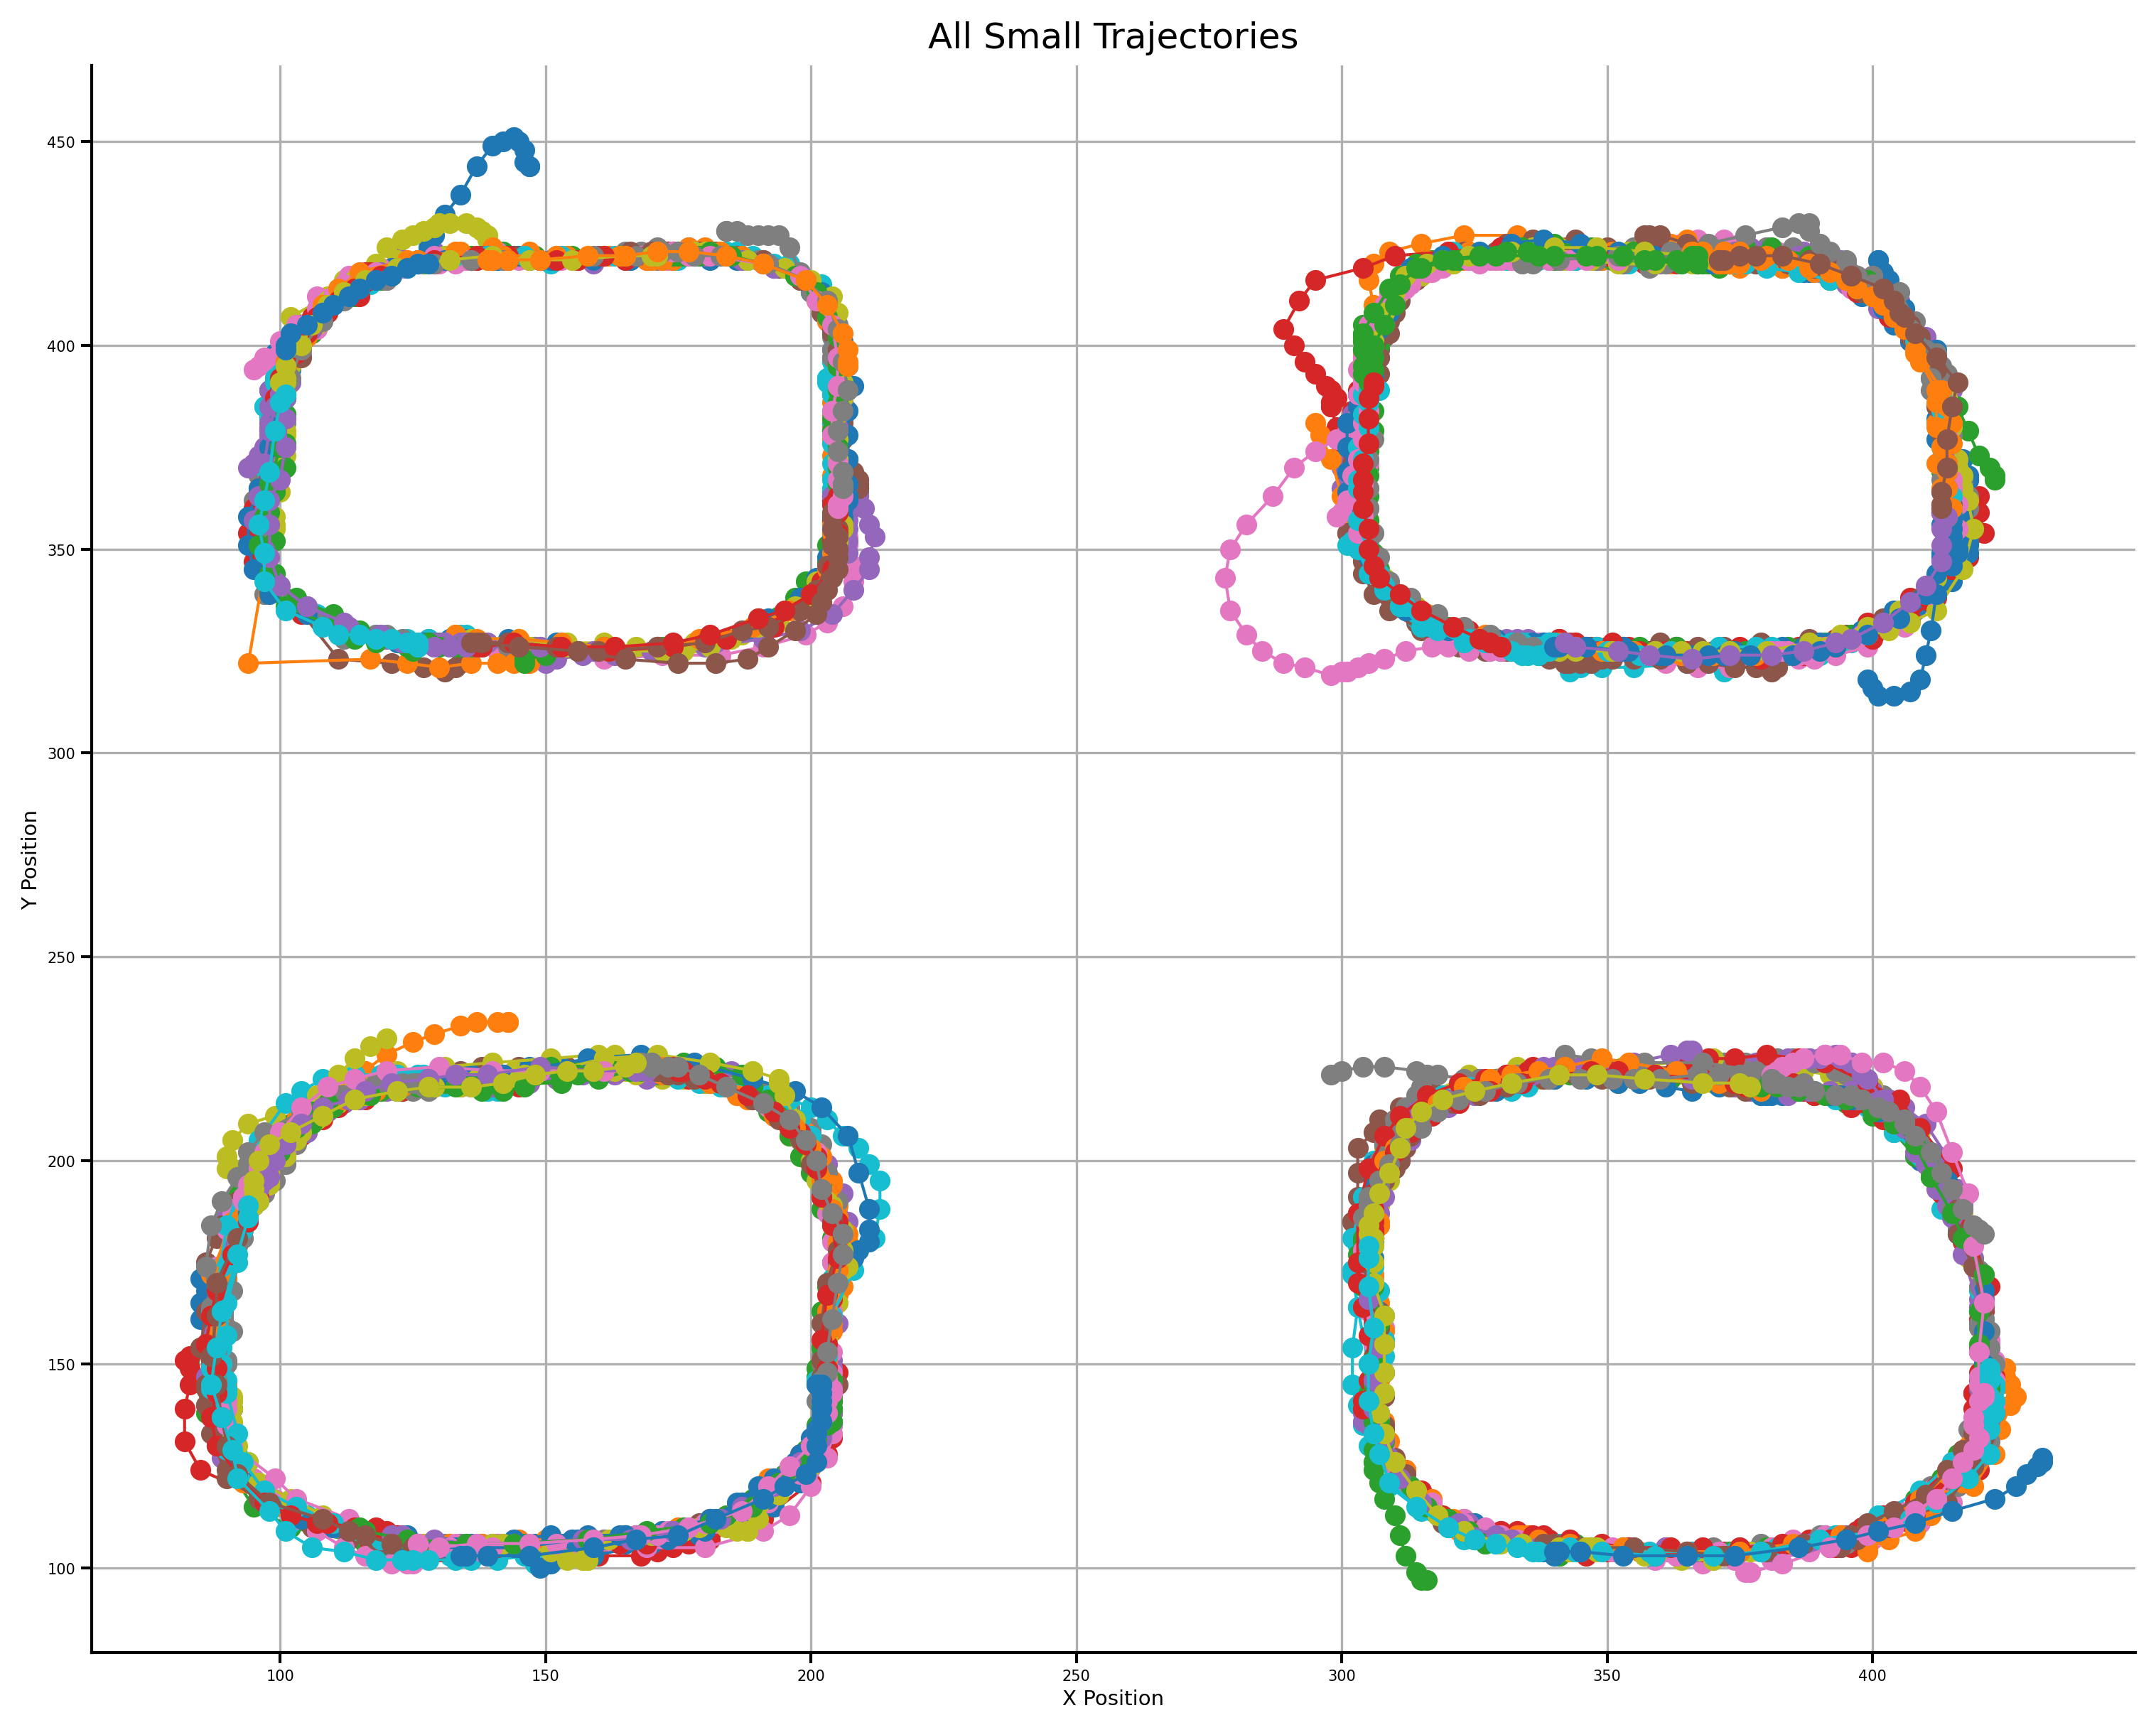

In [34]:
import matplotlib.pyplot as plt
import numpy as np


# Function to plot all small trajectories on the same graph
def plot_all_trajectories(traj_df, list_quarter_turn):
    plt.figure(figsize=(10, 8))
    
    for thisQT in list_quarter_turn:
        start_index, end_index = thisQT[0], thisQT[1]
        
        # Check if the indexes are within the bounds of traj_df
        if start_index < 0 or end_index >= len(traj_df):
            print(f"Indexes out of bounds for thisQT: {thisQT}")
            continue

        # Extract the quarter_turn segment
        quarter_turn = traj_df.iloc[start_index:end_index + 1]

        # Plot the trajectory
        plt.plot(quarter_turn['xposition'], quarter_turn['yposition'], marker='o', linestyle='-', label=f"Traj {start_index}-{end_index}")

    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('All Small Trajectories')
    plt.grid(True)
    #plt.legend()
    plt.show()

# Plot all small trajectories
plot_all_trajectories(traj_df, list_quarter_turn)


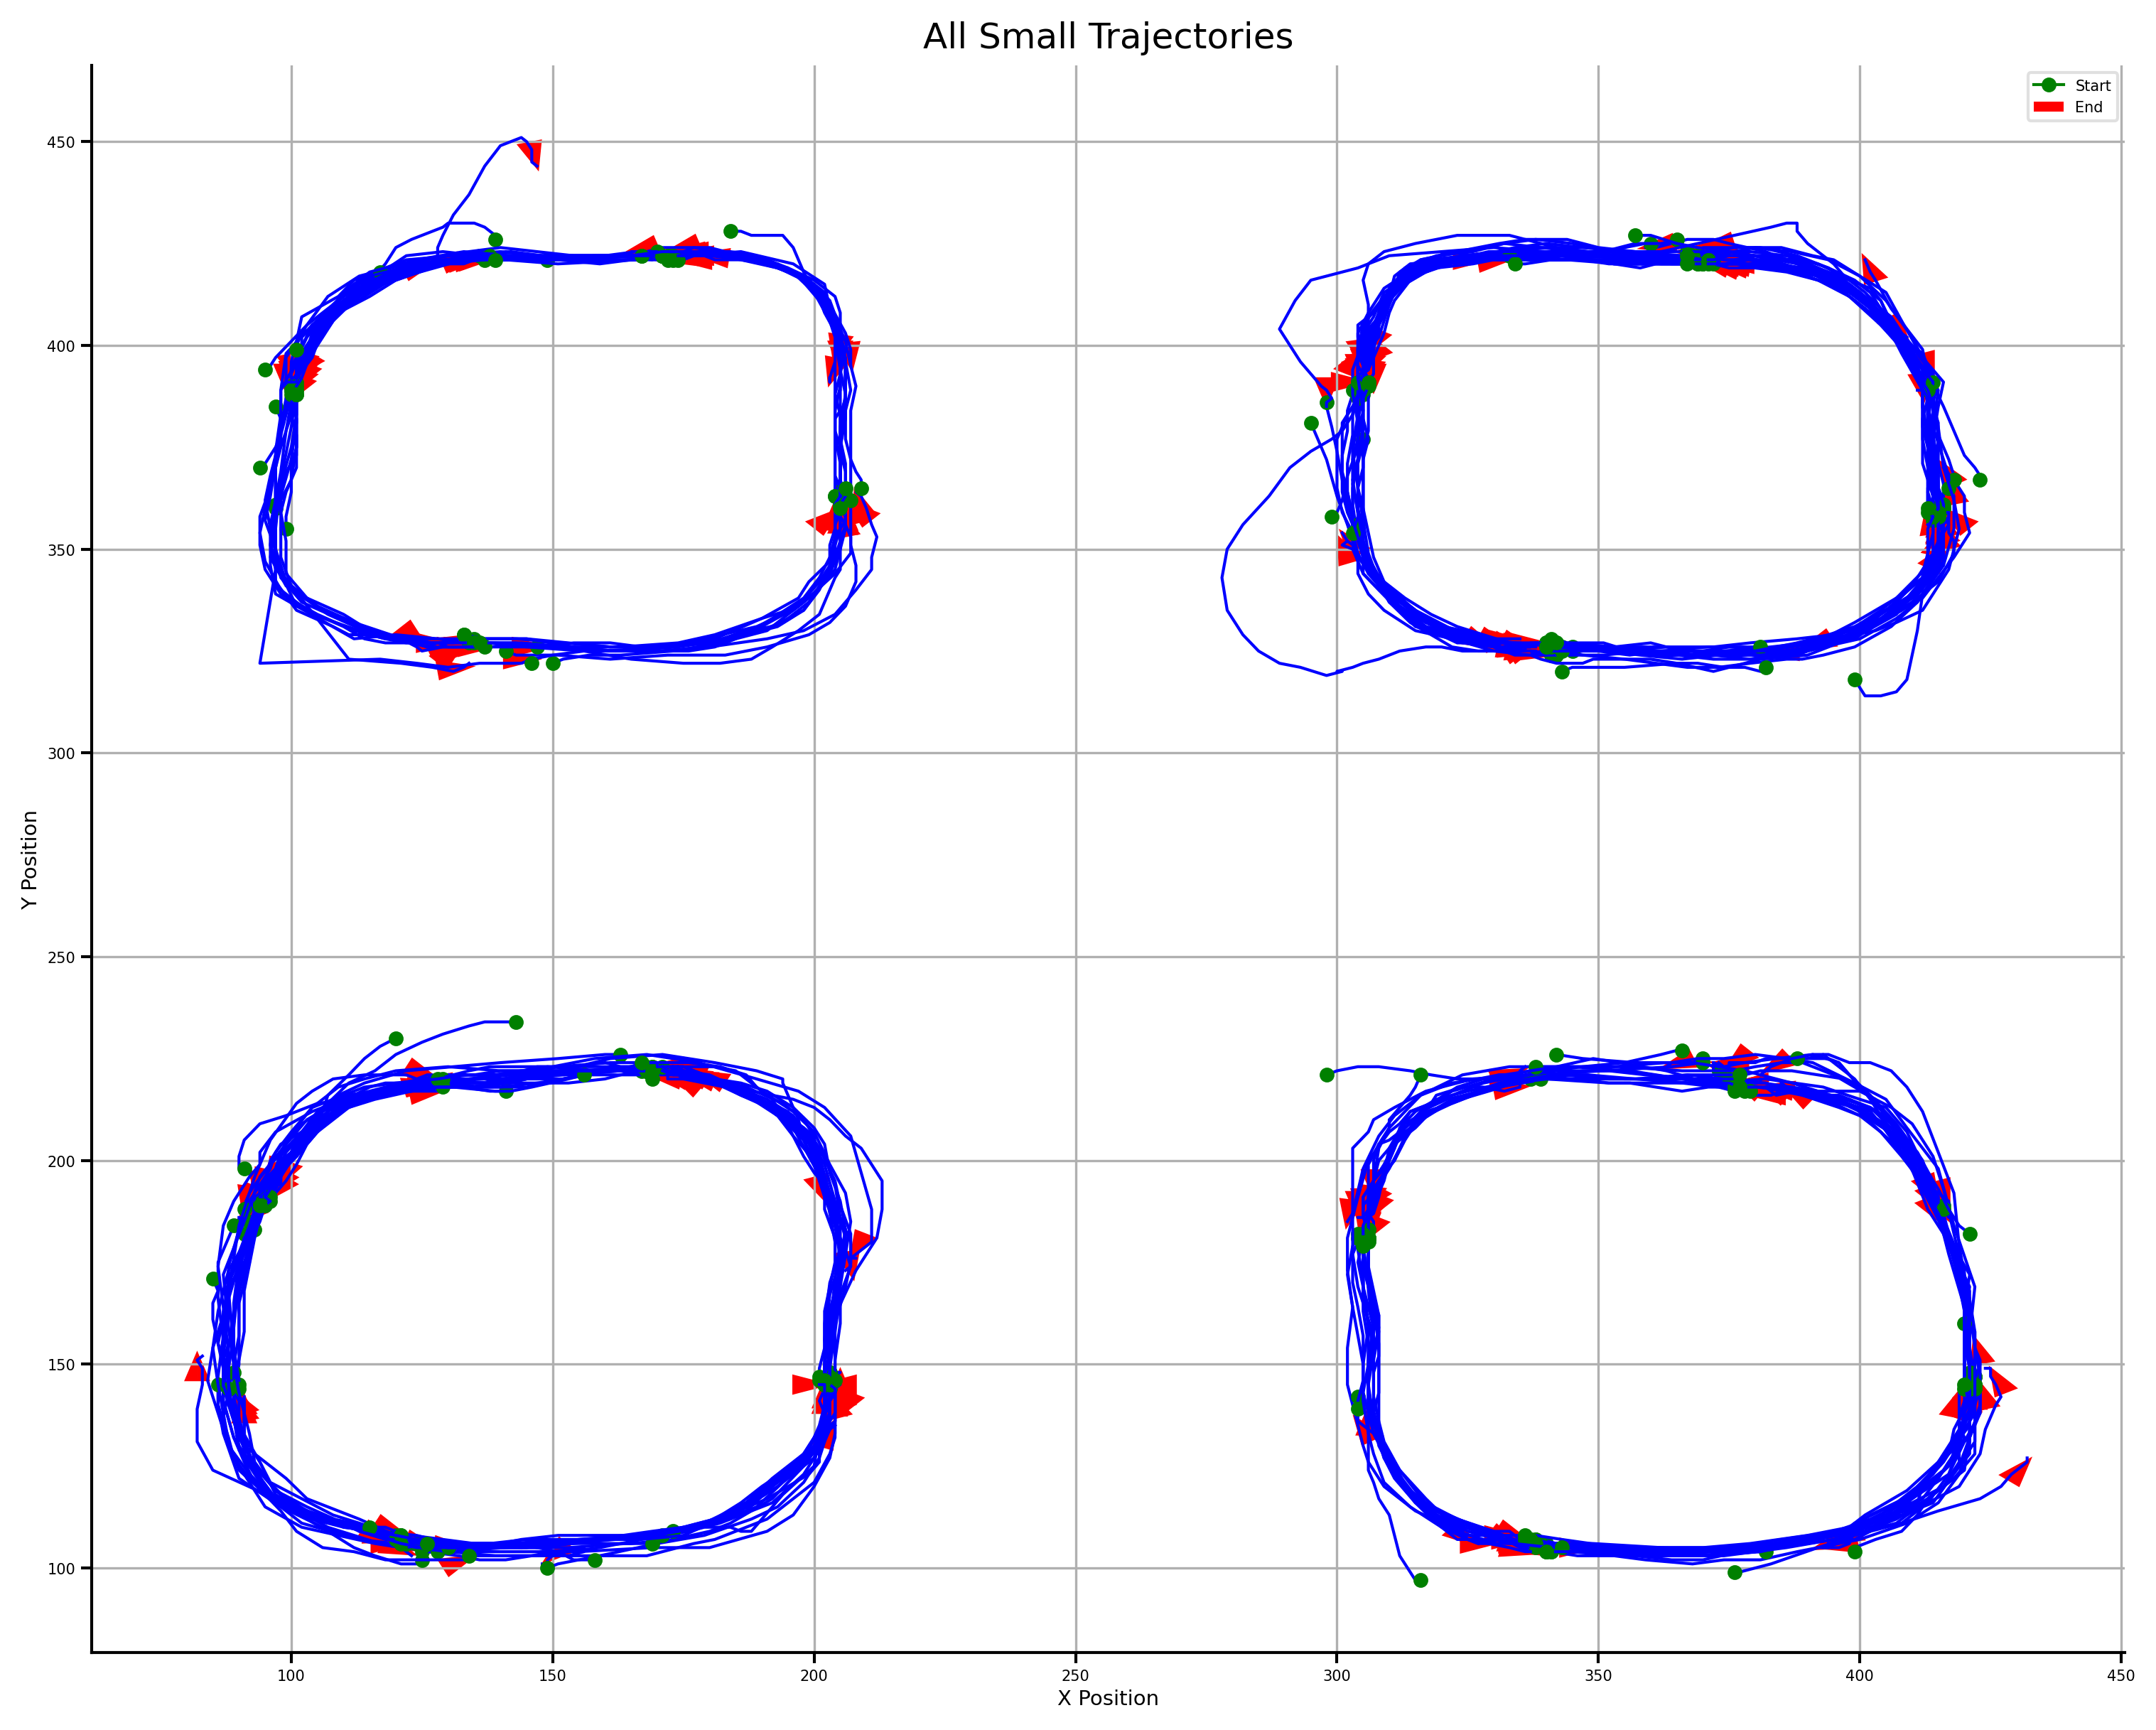

In [36]:


# Function to compute the average angle direction based on the last few points
def compute_average_direction(points):
    diffs = np.diff(points, axis=0)
    avg_diff = np.mean(diffs, axis=0)
    angle = np.arctan2(avg_diff[1], avg_diff[0])
    return avg_diff, angle

# Function to plot all small trajectories on the same graph
def plot_all_trajectories(traj_df, list_quarter_turn, points_for_direction=4):
    plt.figure(figsize=(10, 8))
    
    for idx, thisQT in enumerate(list_quarter_turn):
        start_index, end_index = thisQT[0], thisQT[1]
        
        # Check if the indexes are within the bounds of traj_df
        if start_index < 0 or end_index >= len(traj_df):
            print(f"Indexes out of bounds for thisQT: {thisQT}")
            continue

        # Extract the quarter_turn segment
        quarter_turn = traj_df.iloc[start_index:end_index + 1]

        # Plot the trajectory line
        plt.plot(quarter_turn['xposition'], quarter_turn['yposition'], linestyle='-', color='b')

        # Mark the beginning of the trajectory
        plt.plot(quarter_turn['xposition'].iloc[0], quarter_turn['yposition'].iloc[0], 
                 marker='o', color='g', markersize=4, 
                 label='Start' if idx == 0 else "")

        # Compute the average direction based on the last few points
        end_points = quarter_turn[['xposition', 'yposition']].iloc[-points_for_direction:].values
        avg_diff, angle = compute_average_direction(end_points)

        # Draw an arrow at the end of the trajectory
        plt.arrow(
            quarter_turn['xposition'].iloc[-2], quarter_turn['yposition'].iloc[-2], 
            avg_diff[0], avg_diff[1],
            shape='full', lw=0, length_includes_head=True, head_width=5, color='r',
            label='End' if idx == 0 else ""
        )

    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('All Small Trajectories')
    plt.grid(True)
    plt.legend()
    plt.show()

# Assuming you have traj_df and list_quarter_turn already defined
plot_all_trajectories(traj_df, list_quarter_turn, points_for_direction=4)


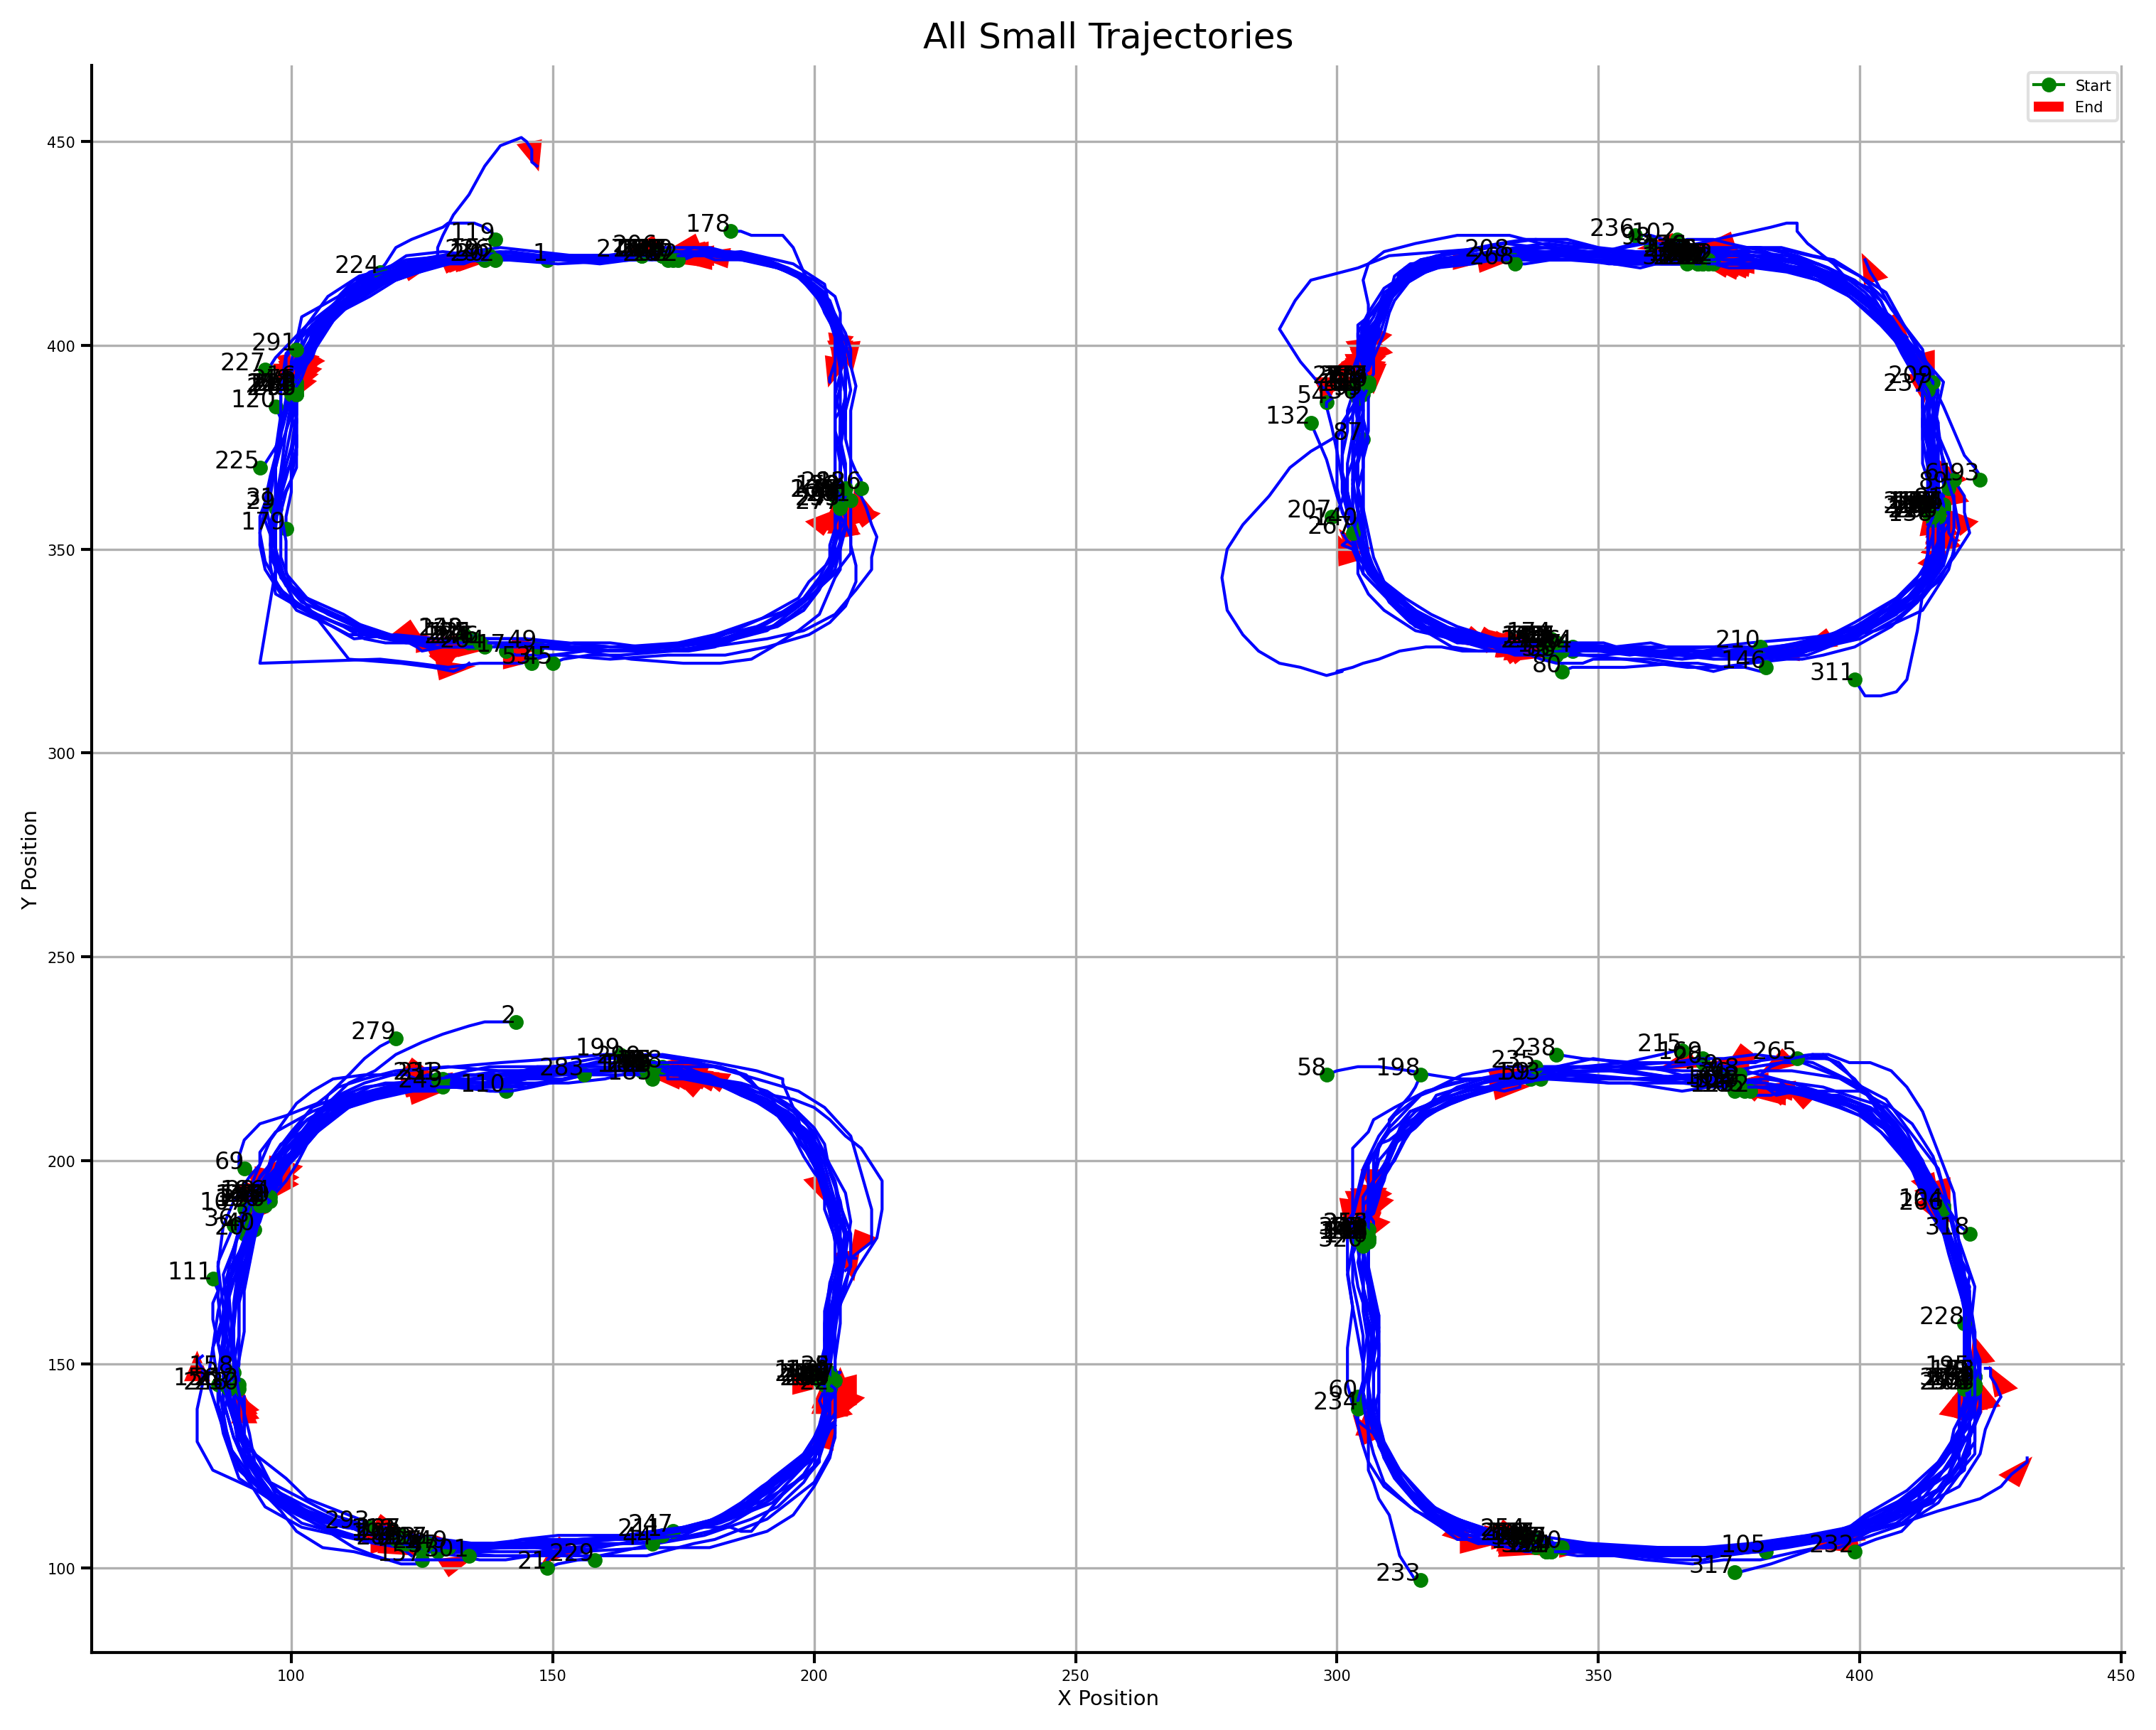

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Function to compute the average angle direction based on the last few points
def compute_average_direction(points):
    diffs = np.diff(points, axis=0)
    avg_diff = np.mean(diffs, axis=0)
    angle = np.arctan2(avg_diff[1], avg_diff[0])
    return avg_diff, angle

# Function to plot all small trajectories on the same graph
def plot_all_trajectories(traj_df, list_quarter_turn, points_for_direction=4):
    plt.figure(figsize=(10, 8))
    
    for idx, thisQT in enumerate(list_quarter_turn):
        start_index, end_index = thisQT[0], thisQT[1]
        
        # Check if the indexes are within the bounds of traj_df
        if start_index < 0 or end_index >= len(traj_df):
            print(f"Indexes out of bounds for thisQT: {thisQT}")
            continue

        # Extract the quarter_turn segment
        quarter_turn = traj_df.iloc[start_index:end_index + 1]

        # Plot the trajectory line
        plt.plot(quarter_turn['xposition'], quarter_turn['yposition'], linestyle='-', color='b')

        # Mark the beginning of the trajectory
        plt.plot(quarter_turn['xposition'].iloc[0], quarter_turn['yposition'].iloc[0], 
                 marker='o', color='g', markersize=4, 
                 label='Start' if idx == 0 else "")

        # Compute the average direction based on the last few points
        end_points = quarter_turn[['xposition', 'yposition']].iloc[-points_for_direction:].values
        avg_diff, angle = compute_average_direction(end_points)

        # Draw an arrow at the end of the trajectory
        plt.arrow(
            quarter_turn['xposition'].iloc[-2], quarter_turn['yposition'].iloc[-2], 
            avg_diff[0], avg_diff[1],
            shape='full', lw=0, length_includes_head=True, head_width=5, color='r',
            label='End' if idx == 0 else ""
        )

        # Annotate the number of the quarter turn next to its starting point
        plt.text(quarter_turn['xposition'].iloc[0], quarter_turn['yposition'].iloc[0], f'{idx + 1}', fontsize=8, color='black', ha='right')

    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('All Small Trajectories')
    plt.grid(True)
    plt.legend()
    plt.show()

# Assuming you have traj_df and list_quarter_turn already defined
plot_all_trajectories(traj_df, list_quarter_turn, points_for_direction=4)


In [ ]:
for patch in collection_trapeze:  # plot the trapeze around the object
        for trapeze in collection_trapeze[patch]:
            shape = Polygon(np.array(collection_trapeze[patch][trapeze]), color="lemonchiffon")
            ax1.add_patch(shape)
        for u in current_movement:  # plot each individual trajectory of the current category
            colors = plt.cm.rainbow(np.random.random())
            if len(u) != 0:
                ax1.plot(xgauss[u[0]:u[1]], ygauss[u[0]:u[1]], lw=0.5, c=colors)
            else:
                pass

310 327
330 351
357 372
387 403
474 487
496 513


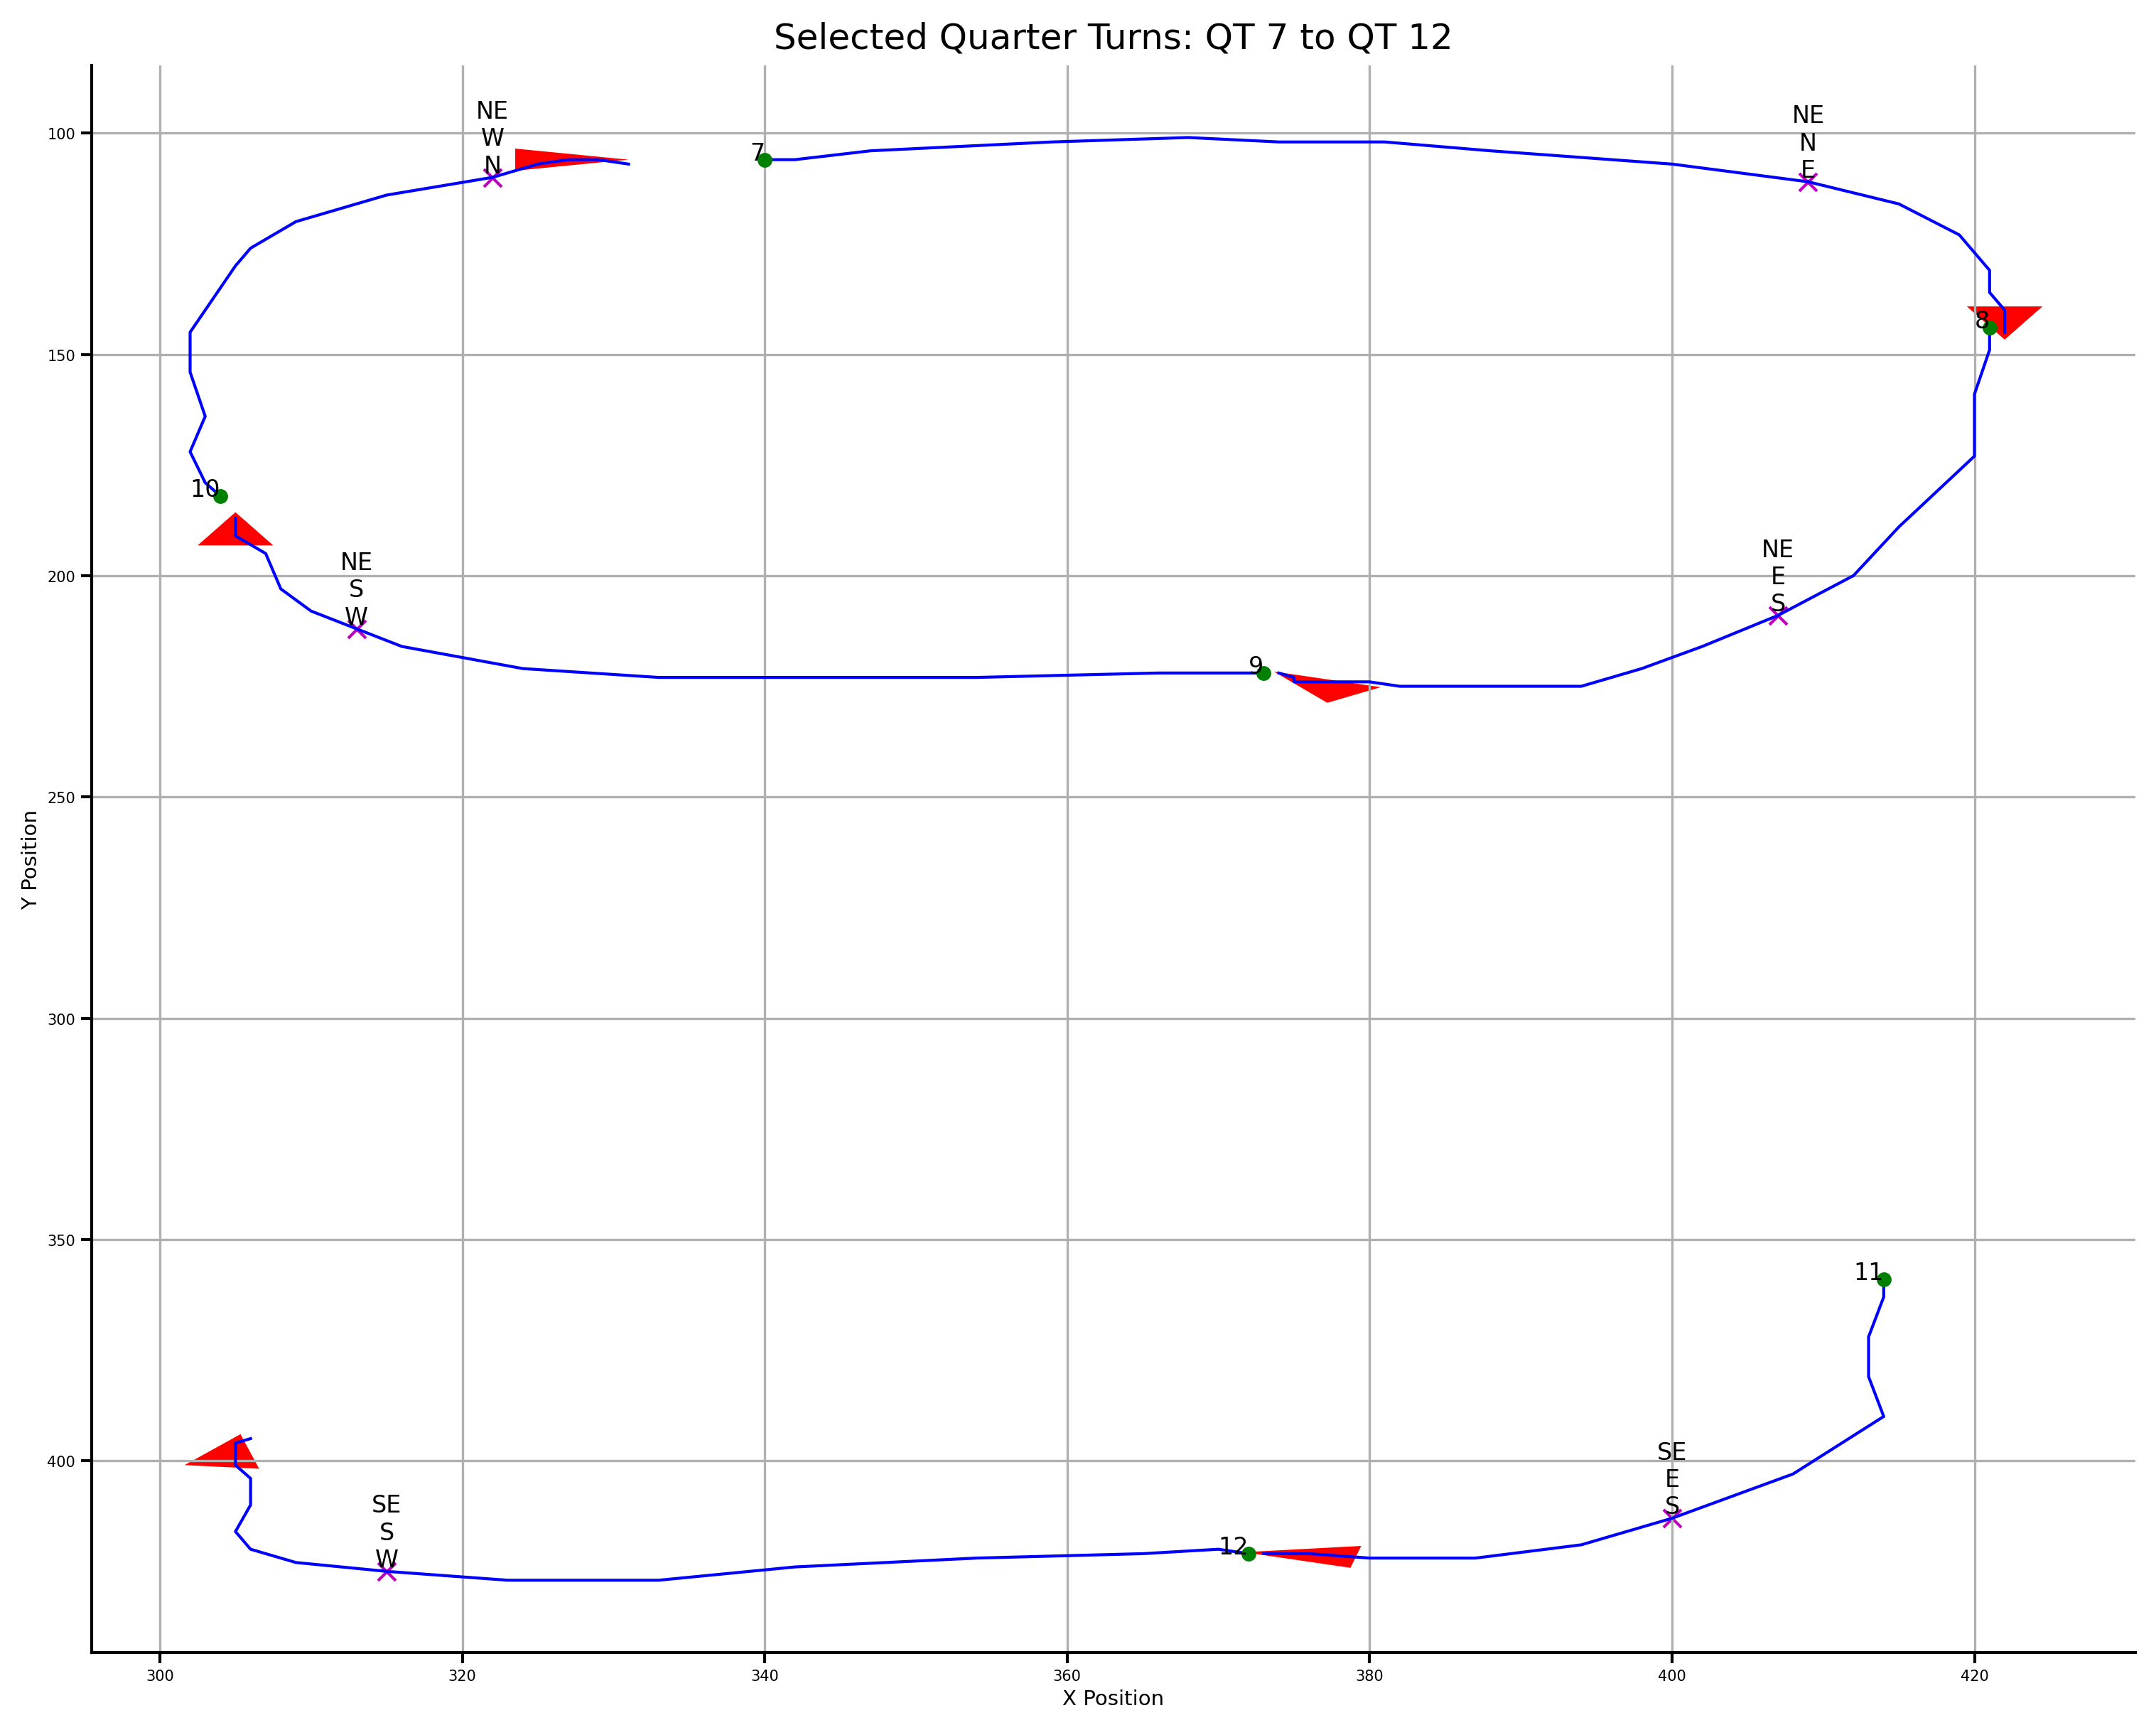

In [61]:

# Function to compute the average angle direction based on the last few points
def compute_average_direction(points):
    diffs = np.diff(points, axis=0)
    avg_diff = np.mean(diffs, axis=0)
    angle = np.arctan2(avg_diff[1], avg_diff[0])
    return avg_diff, angle

# Function to plot selected small trajectories on the same graph
def plot_selected_trajectories(traj_df, list_quarter_turn, turns_df, start_idx, end_idx, points_for_direction=4):
    plt.figure(figsize=(10, 8))

    for idx in range(start_idx, end_idx):
        thisQT = list_quarter_turn[idx]
        start_index, end_index = thisQT[0], thisQT[1]
        print(start_index,end_index)

        # Check if the indexes are within the bounds of traj_df
        if start_index < 0 or end_index >= len(traj_df):
            print(f"Indexes out of bounds for thisQT: {thisQT}")
            continue

        # Extract the quarter_turn segment
        quarter_turn = traj_df.iloc[start_index:end_index + 1]

        # Plot the trajectory line
        plt.plot(quarter_turn['xposition'], quarter_turn['yposition'], linestyle='-', color='b')

        # Mark the beginning of the trajectory
        plt.plot(quarter_turn['xposition'].iloc[0], quarter_turn['yposition'].iloc[0], 
                 marker='o', color='g', markersize=4, 
                 label='Start' if idx == start_idx else "")

        # Compute the average direction based on the last few points
        end_points = quarter_turn[['xposition', 'yposition']].iloc[-points_for_direction:].values
        avg_diff, angle = compute_average_direction(end_points)

        # Draw an arrow at the end of the trajectory
        plt.arrow(
            quarter_turn['xposition'].iloc[-2], quarter_turn['yposition'].iloc[-2], 
            avg_diff[0], avg_diff[1],
            shape='full', lw=0, length_includes_head=True, head_width=5, color='r',
            label='End' if idx == start_idx else ""
        )

        # Annotate the number of the quarter turn next to its starting point
        plt.text(quarter_turn['xposition'].iloc[0], quarter_turn['yposition'].iloc[0], f'{idx + 1}', fontsize=8, color='black', ha='right')

        # Find turns within this quarter turn based on time
        turns_in_QT = turns_df[(turns_df['time'] >= quarter_turn['time'].iloc[0]) & (turns_df['time'] <= quarter_turn['time'].iloc[-1])]

        # Plot turns as markers on the trajectory
        plt.scatter(turns_in_QT['xposition'], turns_in_QT['yposition'], marker='x', color='m', label='Turn Positions')

        # Add labels to turns indicating currentPatch, previousTrapeze, and currentTrapeze
        for _, turn in turns_in_QT.iterrows():
            plt.text(turn['xposition'], turn['yposition'], f"{turn['currentPatch']}\n{turn['previousTrapeze']}\n{turn['currentTrapeze']}",
                     fontsize=8, color='black', ha='center', va='bottom')

    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Selected Quarter Turns: QT {start_idx + 1} to QT {end_idx}')
    plt.grid(True)
    #plt.legend()
    plt.gca().invert_yaxis()  # Invert the y-axis
    plt.show()

# Example usage:
# plot quarter turns 1 to 3
plot_selected_trajectories(traj_df, list_quarter_turn, turns_df, start_idx=6, end_idx=12, points_for_direction=4)


## Explanation:

### Initialization and Plotting
- **Create a Plot**: A plot is created using `plt.subplots()`.
- **Loop through Each Quarter Turn**: For each quarter turn in `list_quarter_turn`, the trajectory segments are extracted and plotted.
  - **Annotate Starting Points**: The starting points of the trajectories are annotated.
  - **Draw Direction Arrows**: Direction arrows are drawn to indicate the trajectory direction.
  - **Plot Turn Positions**: Turn positions are plotted on the trajectory.

### Compute Consecutive Quarter Turns
- **Initialize Variables**: Variables are initialized to track the current tower, count, and start time.
- **Loop through Each Quarter Turn**: Each quarter turn is checked for turns within the time range.
  - **Update Count**: The count of consecutive quarter turns is updated based on whether the tower is the same or has changed.
  - **Append Results**: Results are appended to `consecutive_quarter_turns` list when the tower changes.
  - **Append Last Count**: The last tower visit count is appended to the list at the end of the loop.

### Plotting Configuration
- **Set Axis Labels and Title**: Axis labels and title are set for the plot.
- **Configure Grid and Invert Y-Axis**: The grid is enabled, and the y-axis is inverted.
- **Show Plot**: The plot is displayed using `plt.show()`.

### Return Results
- **Return `consecutive_quarter_turns`**: The function returns `consecutive_quarter_turns`, containing the start time, end time, tower label, and number of consecutive quarter turns for each tower visit.

### Example Usage
- **Call the Function**: The function is called to plot all quarter turns and compute the consecutive quarter turns.
- **Print the Results**: The results are printed.

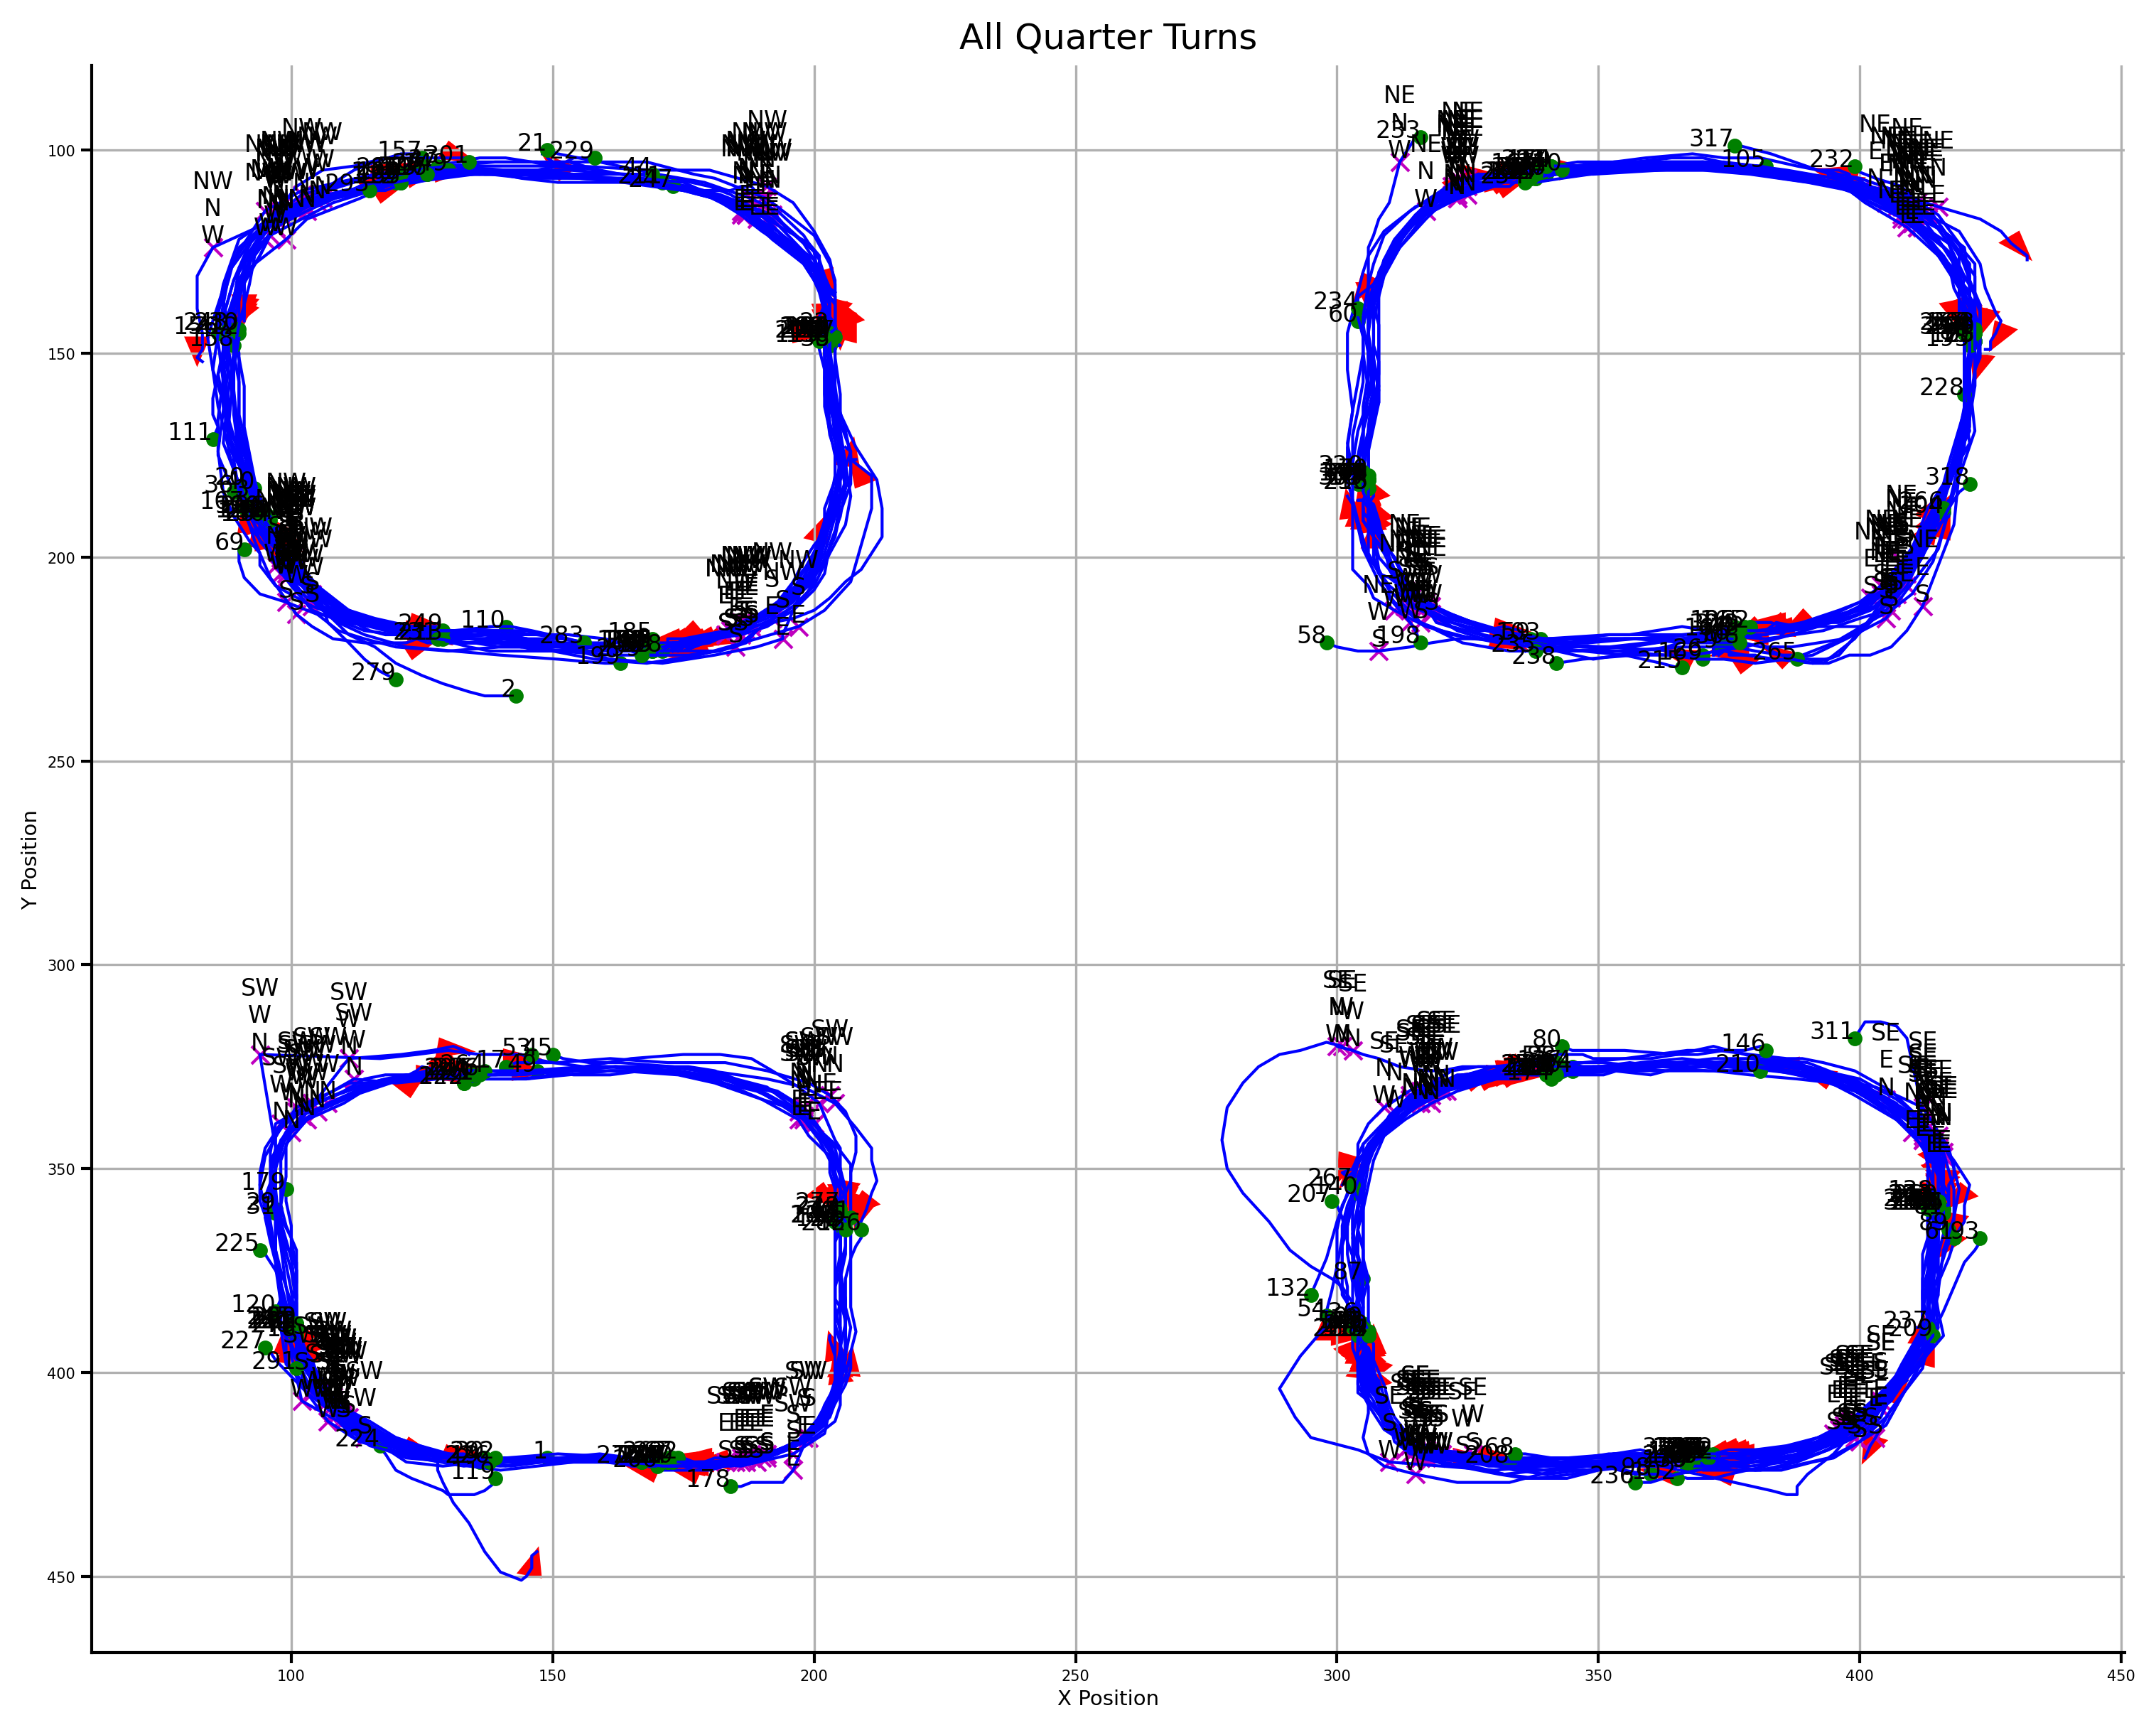

[np.float64(15.034), np.float64(15.634), 'SW', 1]
[np.float64(18.355), np.float64(24.48), 'NW', 5]
[np.float64(27.482), np.float64(31.203), 'NE', 4]
[np.float64(34.045), np.float64(38.047), 'SE', 4]
[np.float64(40.168), np.float64(45.61), 'SW', 5]
[np.float64(47.451), np.float64(51.895), 'NW', 4]
[np.float64(55.216), np.float64(57.42), 'NE', 3]
[np.float64(62.461), np.float64(64.101), 'NW', 2]
[np.float64(66.302), np.float64(70.786), 'SW', 3]
[np.float64(81.351), np.float64(84.592), 'SE', 3]
[np.float64(87.073), np.float64(103.24), 'NW', 10]
[np.float64(104.361), np.float64(114.848), 'SW', 9]
[np.float64(116.529), np.float64(120.01), 'SE', 4]
[np.float64(121.532), np.float64(125.093), 'NE', 3]
[np.float64(127.135), np.float64(132.858), 'SE', 6]
[np.float64(134.578), np.float64(138.42), 'SW', 2]
[np.float64(147.743), np.float64(148.345), 'NW', 1]
[np.float64(150.426), np.float64(160.993), 'NE', 10]
[np.float64(162.273), np.float64(173.76), 'SE', 11]
[np.float64(179.842), np.float64(181.

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to compute the average angle direction based on the last few points
def compute_average_direction(points):
    diffs = np.diff(points, axis=0)
    avg_diff = np.mean(diffs, axis=0)
    angle = np.arctan2(avg_diff[1], avg_diff[0])
    return avg_diff, angle

# Function to plot all small trajectories on the same graph and compute consecutive quarter turns
def plot_all_trajectories(traj_df, list_quarter_turn, turns_df, points_for_direction=4):
    fig, ax = plt.subplots(figsize=(10, 8))

    for idx, thisQT in enumerate(list_quarter_turn):
        start_index, end_index = thisQT[0], thisQT[1]

        # Check if the indexes are within the bounds of traj_df
        if start_index < 0 or end_index >= len(traj_df):
            print(f"Indexes out of bounds for thisQT: {thisQT}")
            continue

        # Extract the quarter_turn segment
        quarter_turn = traj_df.iloc[start_index:end_index + 1]

        # Plot the trajectory line
        ax.plot(quarter_turn['xposition'], quarter_turn['yposition'], linestyle='-', color='b')

        # Mark the beginning of the trajectory
        ax.plot(quarter_turn['xposition'].iloc[0], quarter_turn['yposition'].iloc[0], 
                marker='o', color='g', markersize=4, 
                label='Start' if idx == 0 else "")

        # Compute the average direction based on the last few points
        end_points = quarter_turn[['xposition', 'yposition']].iloc[-points_for_direction:].values
        avg_diff, angle = compute_average_direction(end_points)

        # Draw an arrow at the end of the trajectory
        ax.arrow(
            quarter_turn['xposition'].iloc[-2], quarter_turn['yposition'].iloc[-2], 
            avg_diff[0], avg_diff[1],
            shape='full', lw=0, length_includes_head=True, head_width=5, color='r',
            label='End' if idx == 0 else ""
        )

        # Annotate the number of the quarter turn next to its starting point
        ax.text(quarter_turn['xposition'].iloc[0], quarter_turn['yposition'].iloc[0], f'{idx + 1}', fontsize=8, color='black', ha='right')

        # Find turns within this quarter turn based on time
        turns_in_QT = turns_df[(turns_df['time'] >= quarter_turn['time'].iloc[0]) & (turns_df['time'] <= quarter_turn['time'].iloc[-1])]

        # Plot turns as markers on the trajectory
        ax.scatter(turns_in_QT['xposition'], turns_in_QT['yposition'], marker='x', color='m', label='Turn Positions')

        # Add labels to turns indicating currentPatch, previousTrapeze, and currentTrapeze
        for _, turn in turns_in_QT.iterrows():
            ax.text(turn['xposition'], turn['yposition'], f"{turn['currentPatch']}\n{turn['previousTrapeze']}\n{turn['currentTrapeze']}",
                    fontsize=8, color='black', ha='center', va='bottom')

    # Compute consecutive quarter turns for each tower visit
    consecutive_quarter_turns = []
    current_tower = None
    current_count = 0
    start_time = None

    for idx, thisQT in enumerate(list_quarter_turn):
        start_index, end_index = thisQT[0], thisQT[1]
        quarter_turn = traj_df.iloc[start_index:end_index + 1]

        # Find turns within this quarter turn based on time
        turns_in_QT = turns_df[(turns_df['time'] >= quarter_turn['time'].iloc[0]) & (turns_df['time'] <= quarter_turn['time'].iloc[-1])]

        if not turns_in_QT.empty:
            tower = turns_in_QT.iloc[0]['currentPatch']
            if tower == current_tower:
                current_count += 1
            else:
                if current_tower is not None:
                    end_time = traj_df.iloc[list_quarter_turn[idx - 1][1]]['time']
                    consecutive_quarter_turns.append([start_time, end_time, current_tower, current_count])
                current_tower = tower
                current_count = 1
                start_time = traj_df.iloc[start_index]['time']
        else:
            if current_tower is not None:
                end_time = traj_df.iloc[end_index]['time']
                consecutive_quarter_turns.append([start_time, end_time, current_tower, current_count])
                current_tower = None
                current_count = 0

    # Append the last count
    if current_tower is not None:
        end_time = traj_df.iloc[list_quarter_turn[-1][1]]['time']
        consecutive_quarter_turns.append([start_time, end_time, current_tower, current_count])

    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title(f'All Quarter Turns')
    ax.grid(True)
    ax.invert_yaxis()  # Invert the y-axis
    #plt.legend()
    plt.show()

    return consecutive_quarter_turns

# Example usage:
# plot all quarter turns
consecutive_quarter_turns = plot_all_trajectories(traj_df, list_quarter_turn, turns_df, points_for_direction=4)

# Print the results
for visit in consecutive_quarter_turns:
    print(visit)


## Explanation:

### Compute Average Direction
- **compute_average_direction(points)**: Computes the average direction of the trajectory based on the last few points.

### Plot All Trajectories
- **plot_all_trajectories(traj_df, list_quarter_turn, turns_df, points_for_direction=4)**: Plots all small trajectories and computes the number of consecutive quarter turns before changing towers.

### Additional Plotting
- **Create Bar Plot**: A bar plot is created to show the number of quarter turns performed at each visit over time.
- **Create Histogram**: A histogram is created to show the distribution of the number of quarter turns performed at each visit.


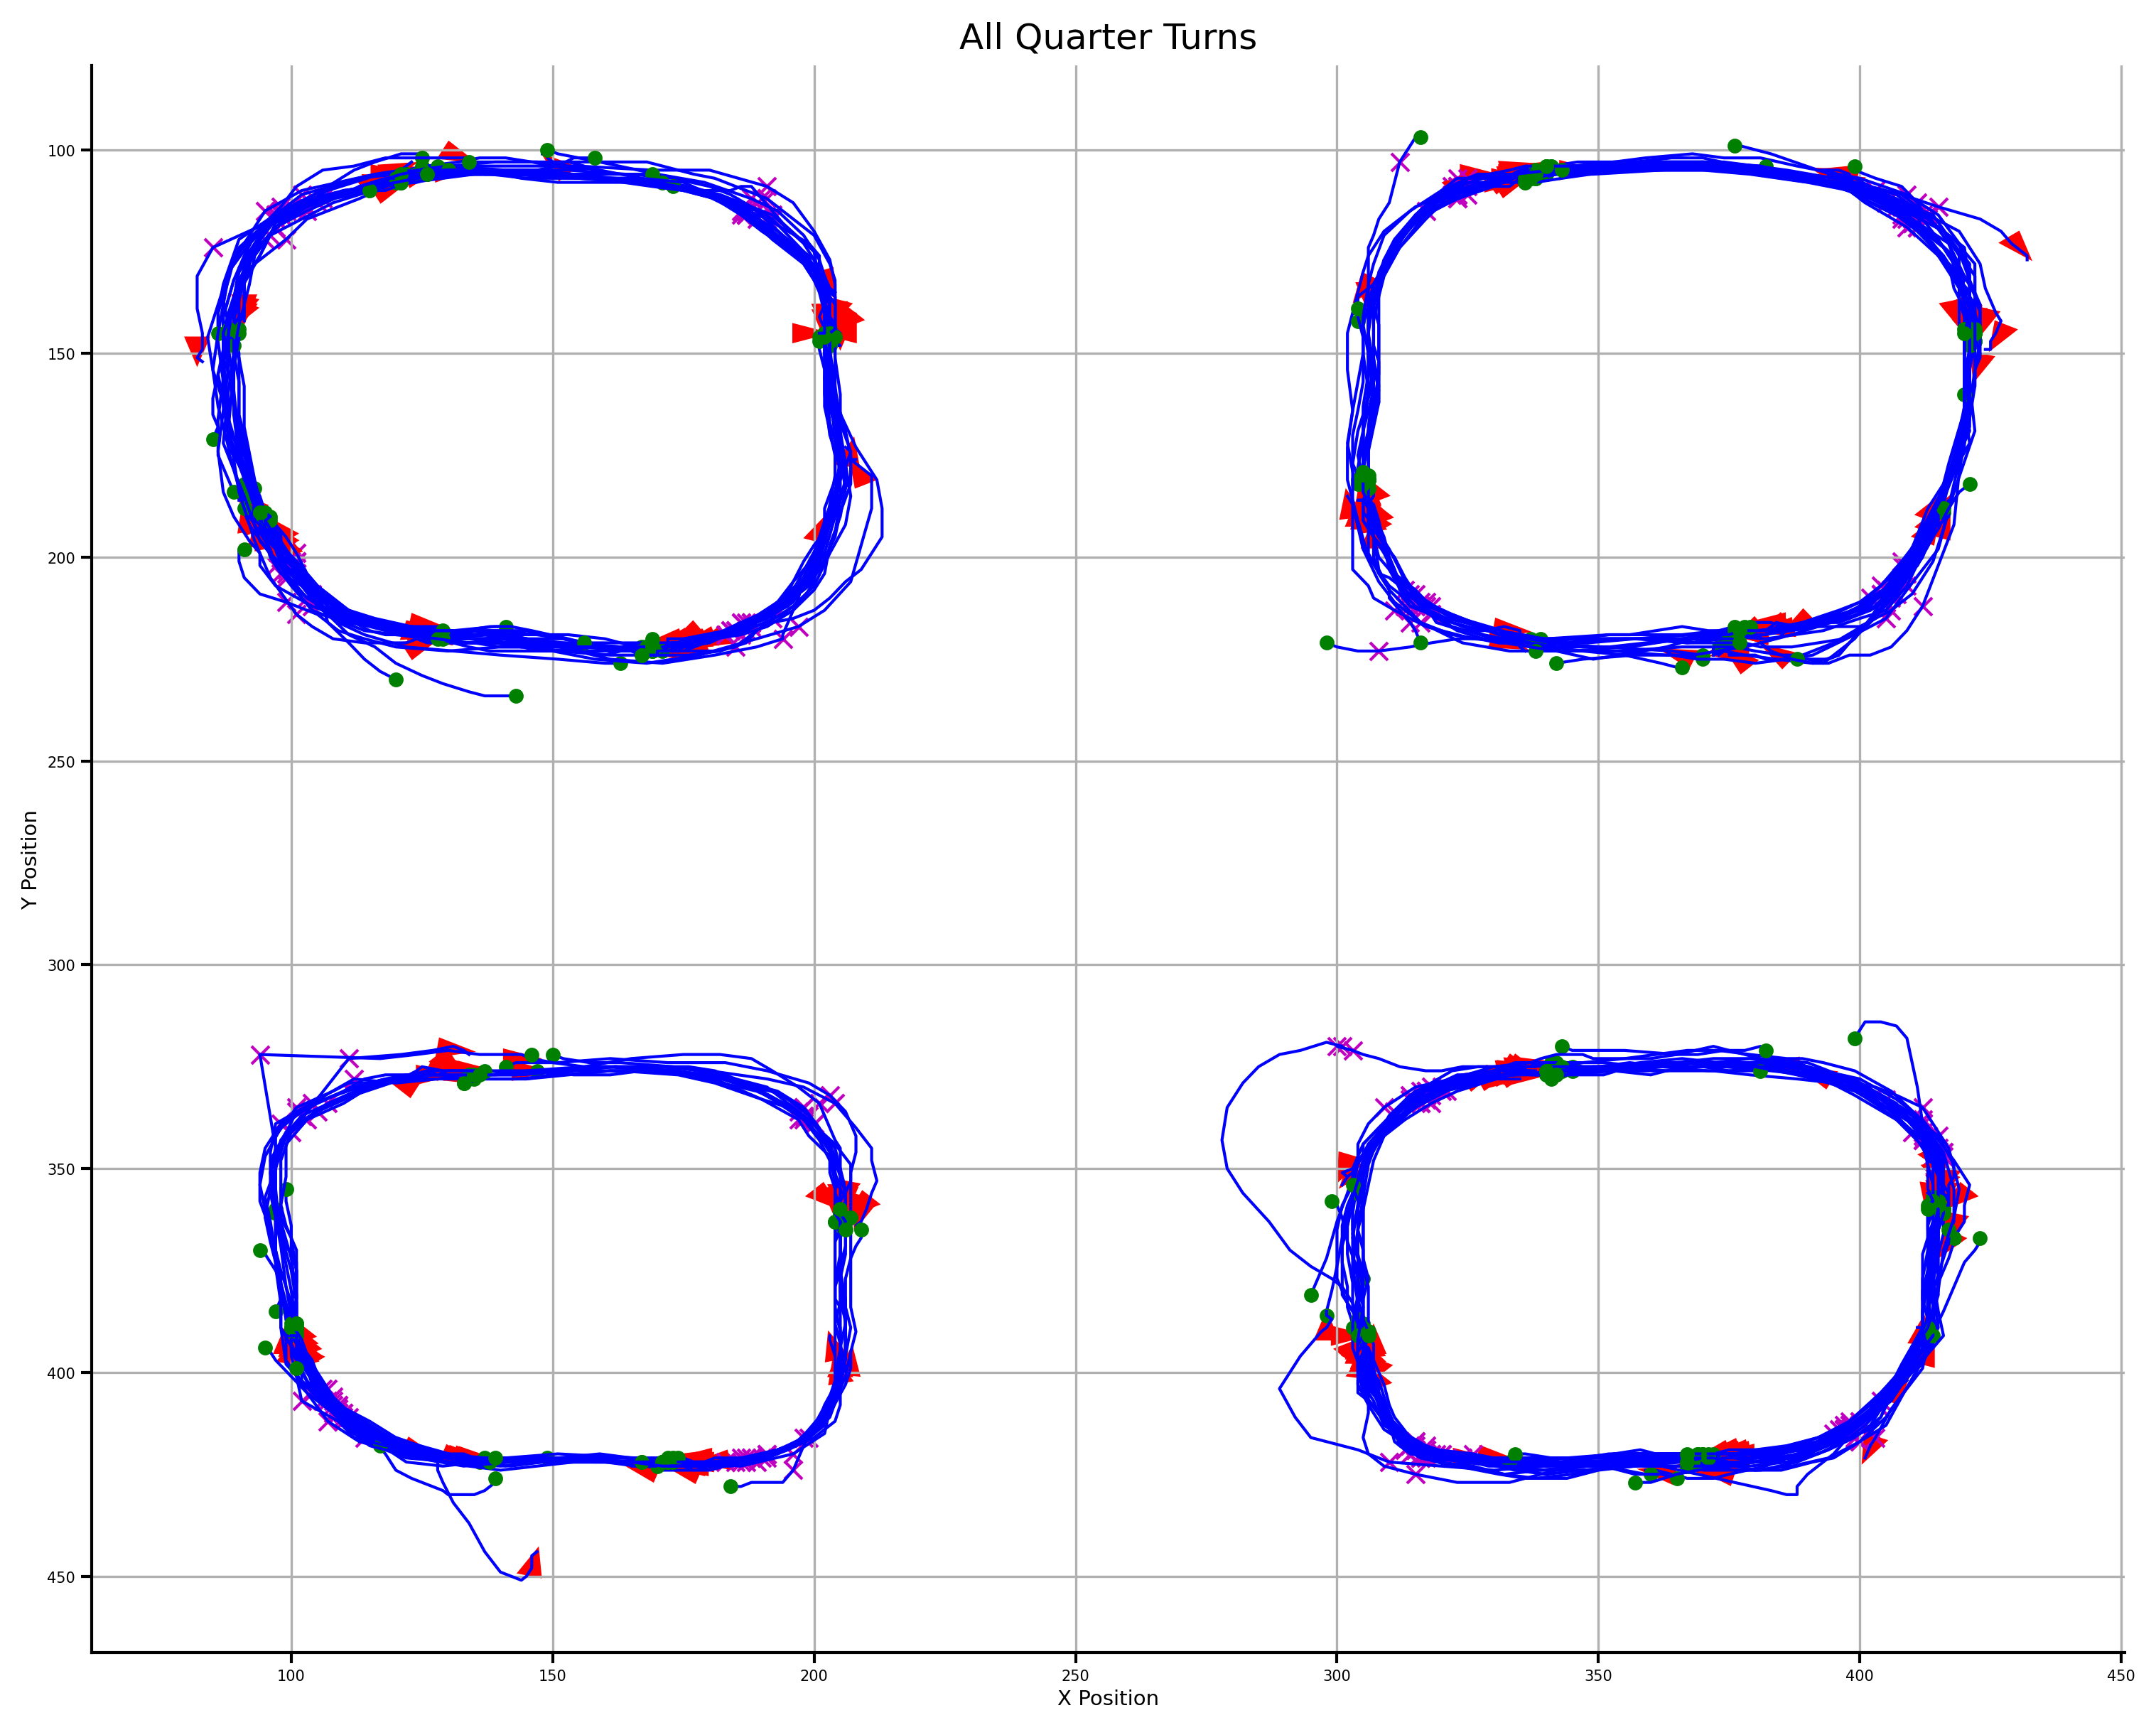

/var/folders/m3/2hk37vnx7xbcrsllbb346xdm0000gn/T/ipykernel_41745/4034936334.py:82: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


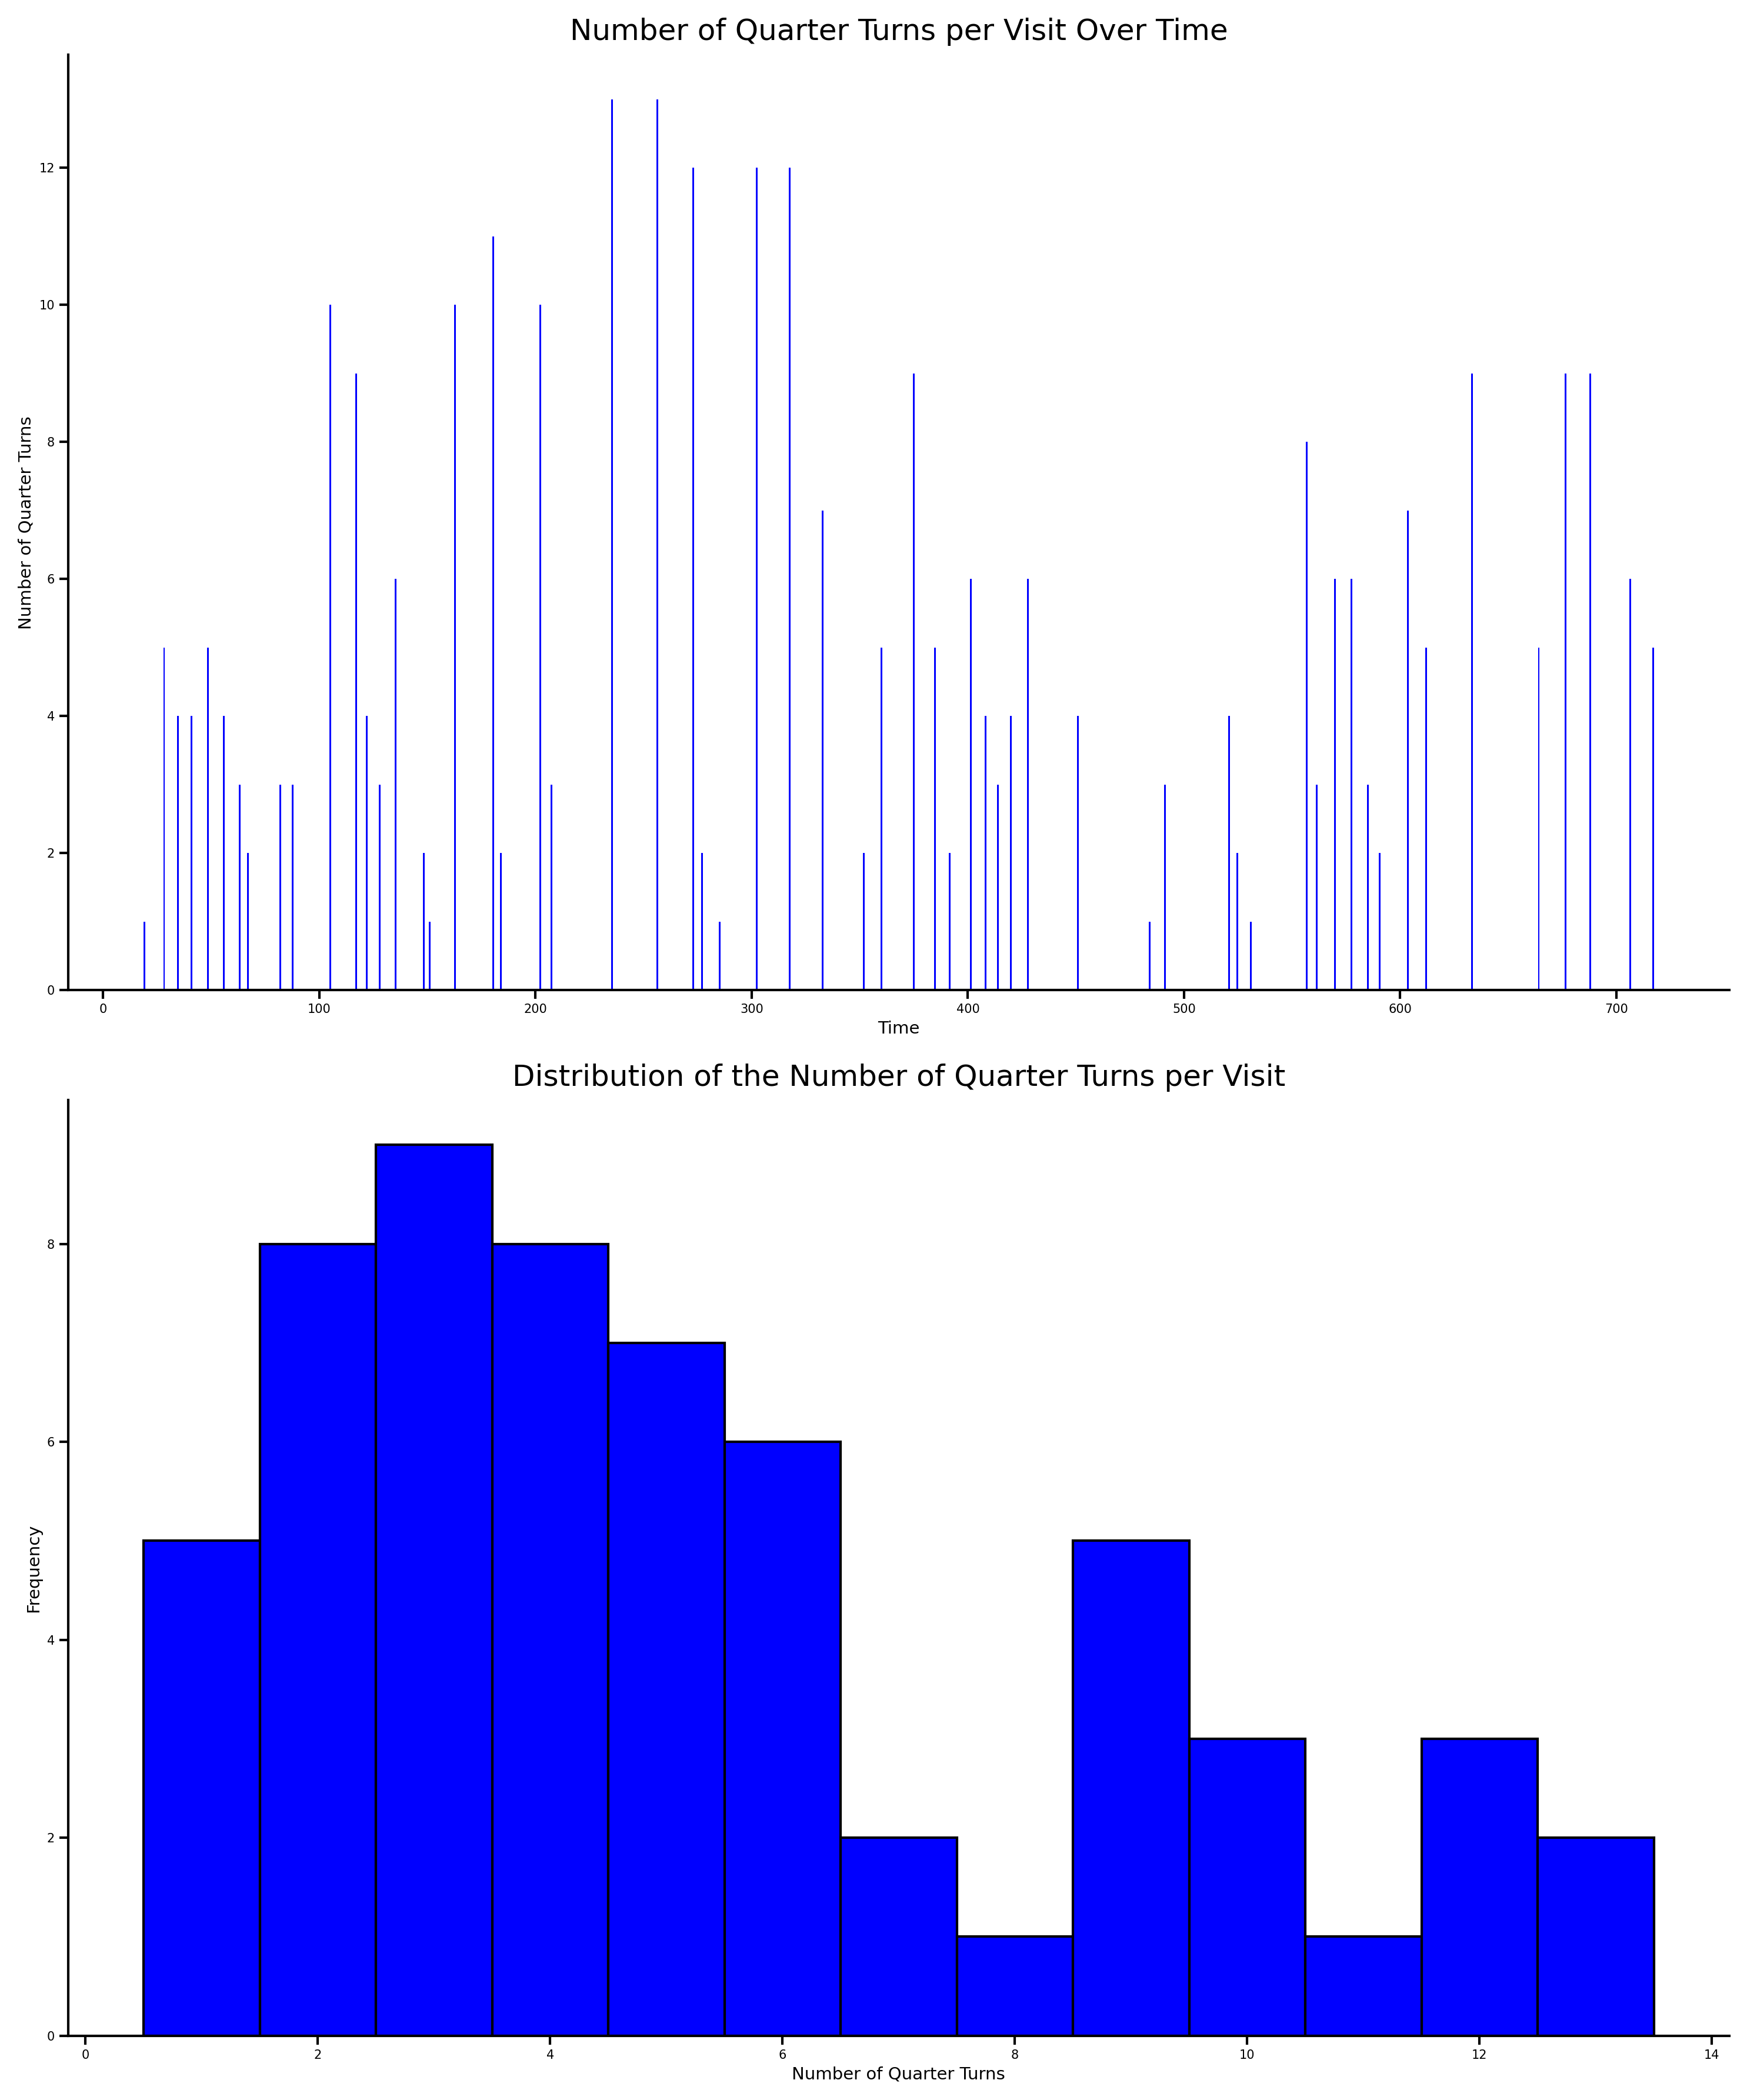

In [51]:


# Function to compute the average angle direction based on the last few points
def compute_average_direction(points):
    diffs = np.diff(points, axis=0)
    avg_diff = np.mean(diffs, axis=0)
    angle = np.arctan2(avg_diff[1], avg_diff[0])
    return avg_diff, angle

# Function to plot all small trajectories on the same graph and compute consecutive quarter turns
def plot_all_trajectories(traj_df, list_quarter_turn, turns_df, points_for_direction=4):
    fig, ax1 = plt.subplots(figsize=(10, 8))

    consecutive_quarter_turns = []
    current_tower = None
    count = 0
    start_time = None

    for idx, thisQT in enumerate(list_quarter_turn):
        start_index, end_index = thisQT[0], thisQT[1]

        if start_index < 0 or end_index >= len(traj_df):
            print(f"Indexes out of bounds for thisQT: {thisQT}")
            continue

        quarter_turn = traj_df.iloc[start_index:end_index + 1]
        ax1.plot(quarter_turn['xposition'], quarter_turn['yposition'], linestyle='-', color='b')
        ax1.plot(quarter_turn['xposition'].iloc[0], quarter_turn['yposition'].iloc[0], 
                 marker='o', color='g', markersize=4, label='Start' if idx == 0 else "")
        end_points = quarter_turn[['xposition', 'yposition']].iloc[-points_for_direction:].values
        avg_diff, angle = compute_average_direction(end_points)
        ax1.arrow(quarter_turn['xposition'].iloc[-2], quarter_turn['yposition'].iloc[-2], 
                  avg_diff[0], avg_diff[1], shape='full', lw=0, length_includes_head=True, 
                  head_width=5, color='r', label='End' if idx == 0 else "")
        
        turns_in_QT = turns_df[(turns_df['time'] >= quarter_turn['time'].iloc[0]) & (turns_df['time'] <= quarter_turn['time'].iloc[-1])]
        
        for _, turn in turns_in_QT.iterrows():
            ax1.scatter(turn['xposition'], turn['yposition'], marker='x', color='m', label='Turn Positions')
        
        if not turns_in_QT.empty:
            current_patch = turns_in_QT.iloc[0]['currentPatch']
            if current_patch != current_tower:
                if current_tower is not None:
                    consecutive_quarter_turns.append([start_time, quarter_turn['time'].iloc[-1], current_tower, count])
                current_tower = current_patch
                start_time = quarter_turn['time'].iloc[0]
                count = 1
            else:
                count += 1

    if current_tower is not None:
        consecutive_quarter_turns.append([start_time, quarter_turn['time'].iloc[-1], current_tower, count])

    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Y Position')
    ax1.set_title('All Quarter Turns')
    ax1.grid(True)
    ax1.invert_yaxis()
    plt.show()

    return consecutive_quarter_turns

# Example usage:
consecutive_quarter_turns = plot_all_trajectories(traj_df, list_quarter_turn, turns_df, points_for_direction=4)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot the number of quarter turns per visit over time
end_times = [entry[1] for entry in consecutive_quarter_turns]
num_turns = [entry[3] for entry in consecutive_quarter_turns]
ax1.bar(end_times, num_turns, color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Quarter Turns')
ax1.set_title('Number of Quarter Turns per Visit Over Time')

# Plot the distribution of the number of quarter turns performed at each visit
ax2.hist(num_turns, bins=np.arange(1, max(num_turns)+2) - 0.5, edgecolor='black', color='blue')
ax2.set_xlabel('Number of Quarter Turns')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of the Number of Quarter Turns per Visit')

plt.tight_layout()
plt.show()


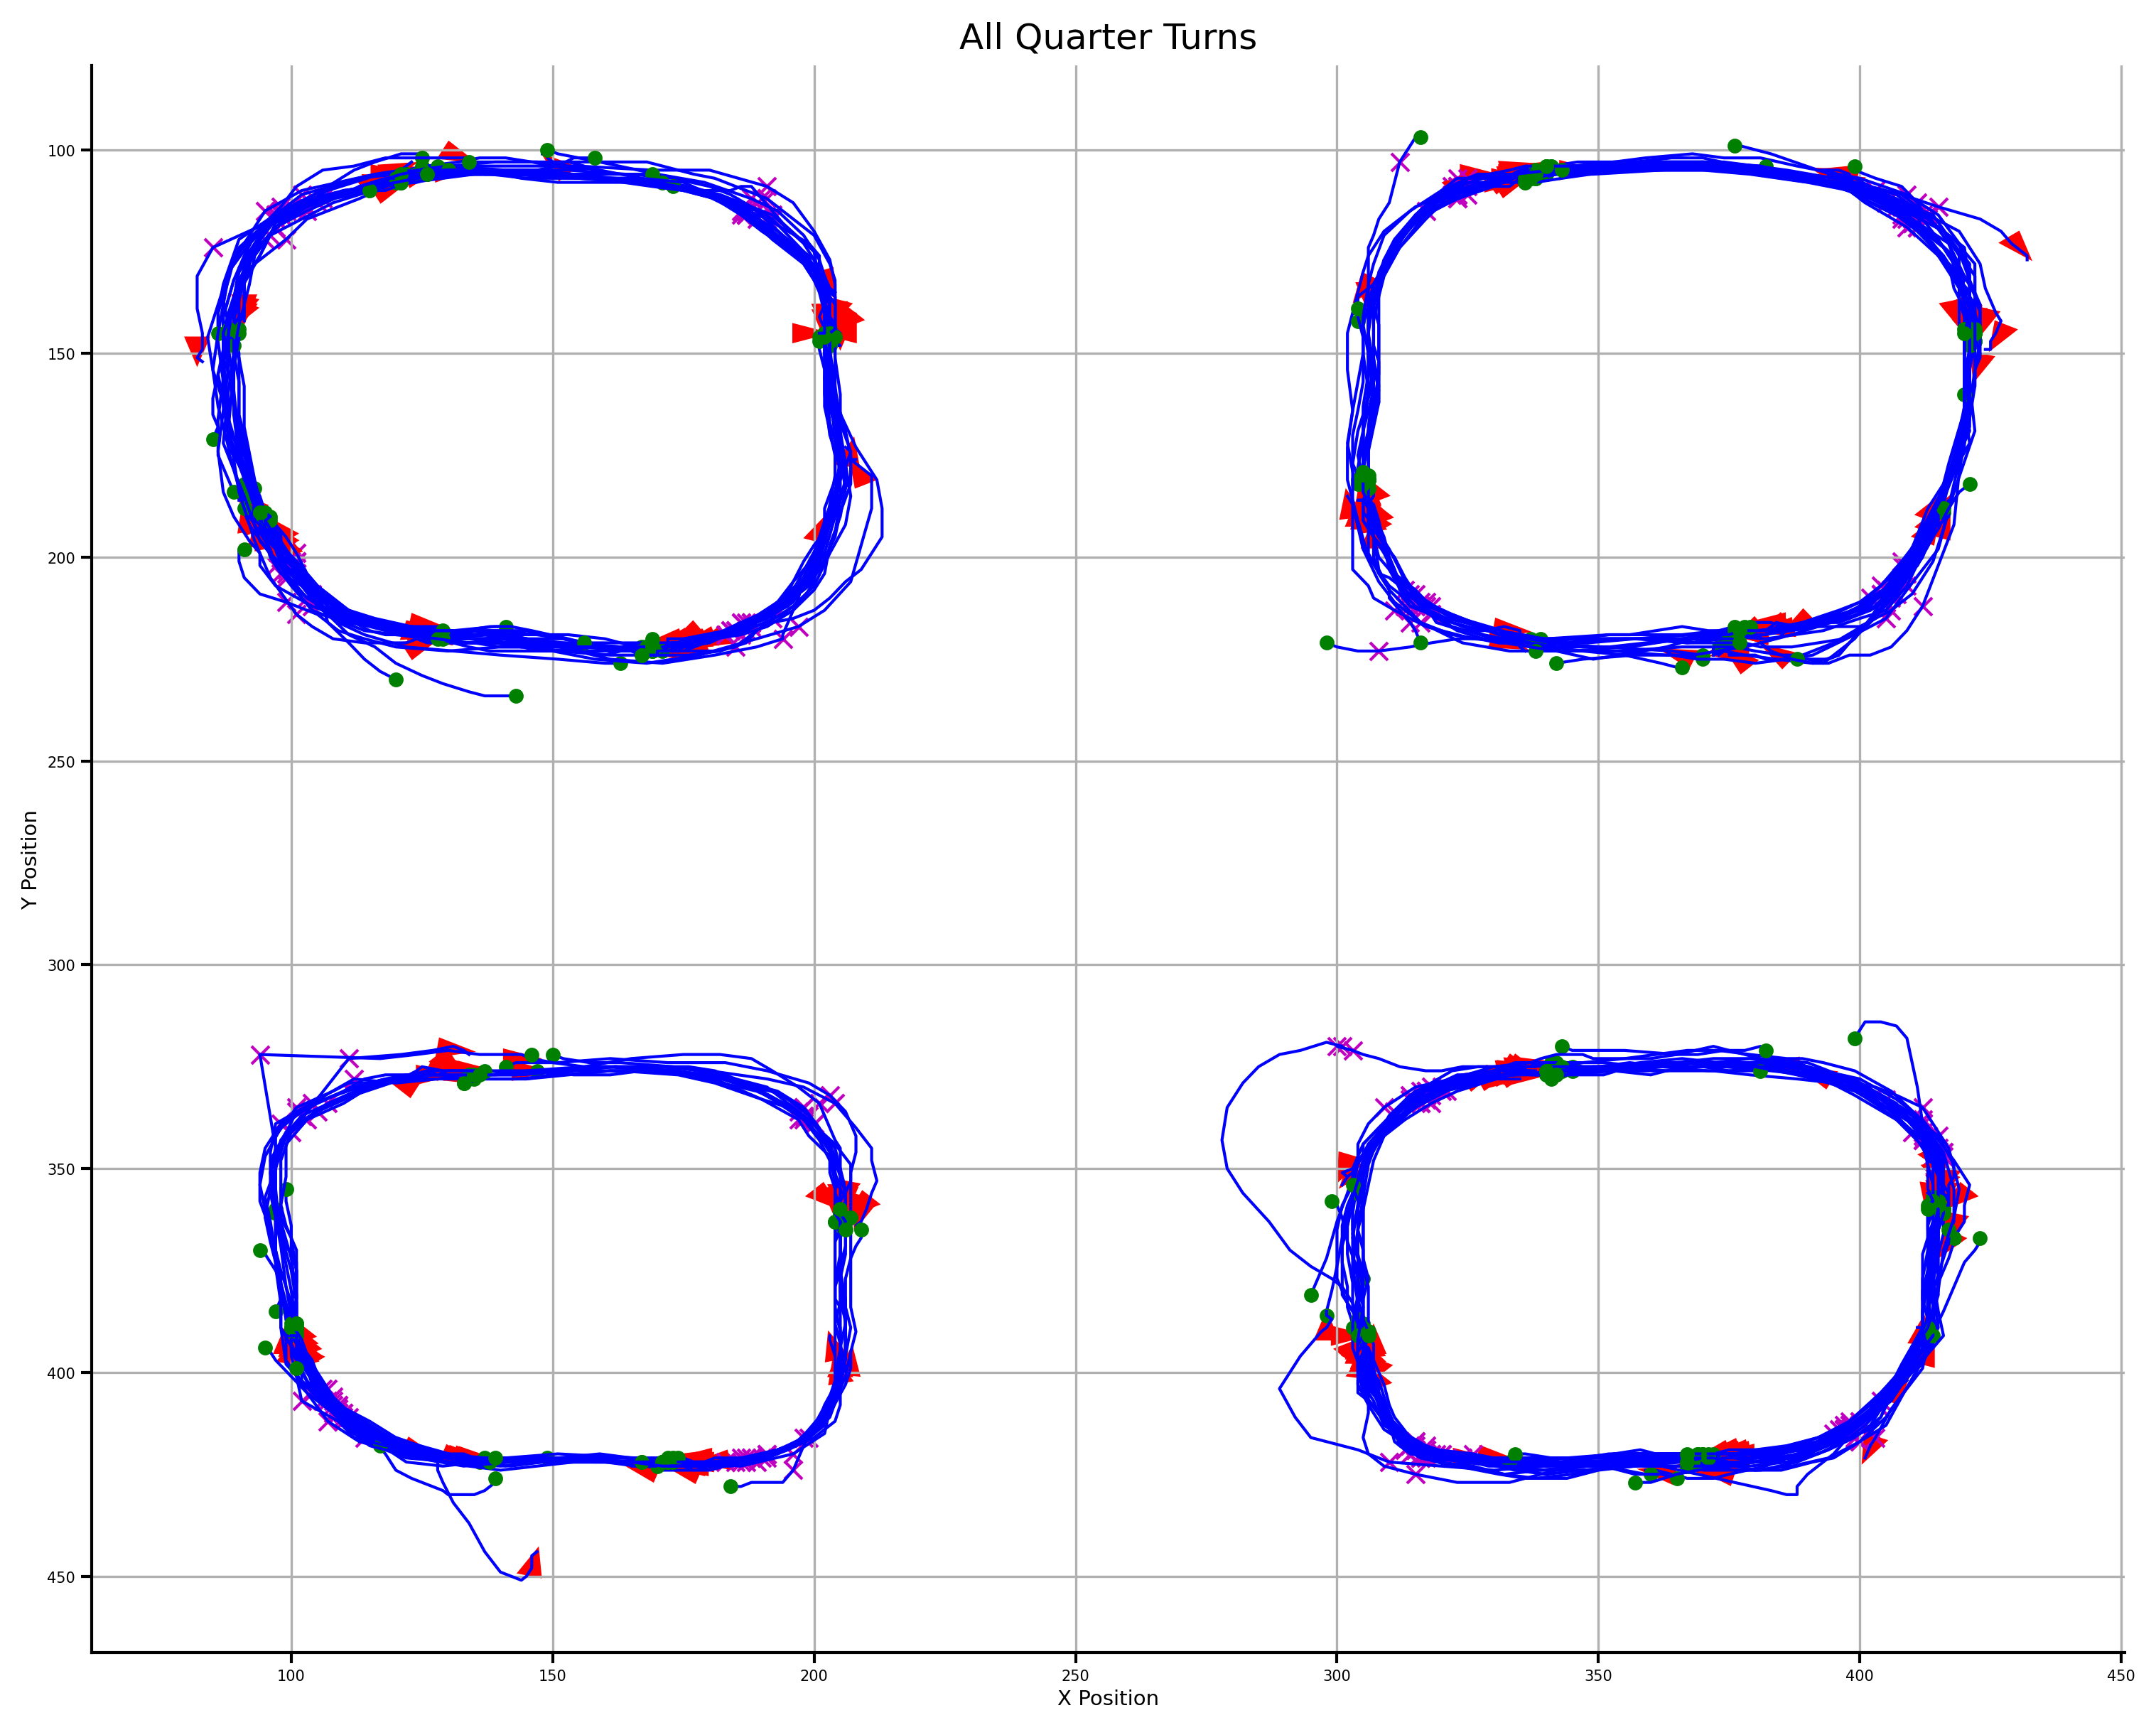

Median number of consecutive quarter turns per visit: 4.5
Median time spent at each tower (in seconds): 9.164999999999992


/var/folders/m3/2hk37vnx7xbcrsllbb346xdm0000gn/T/ipykernel_41745/459559457.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


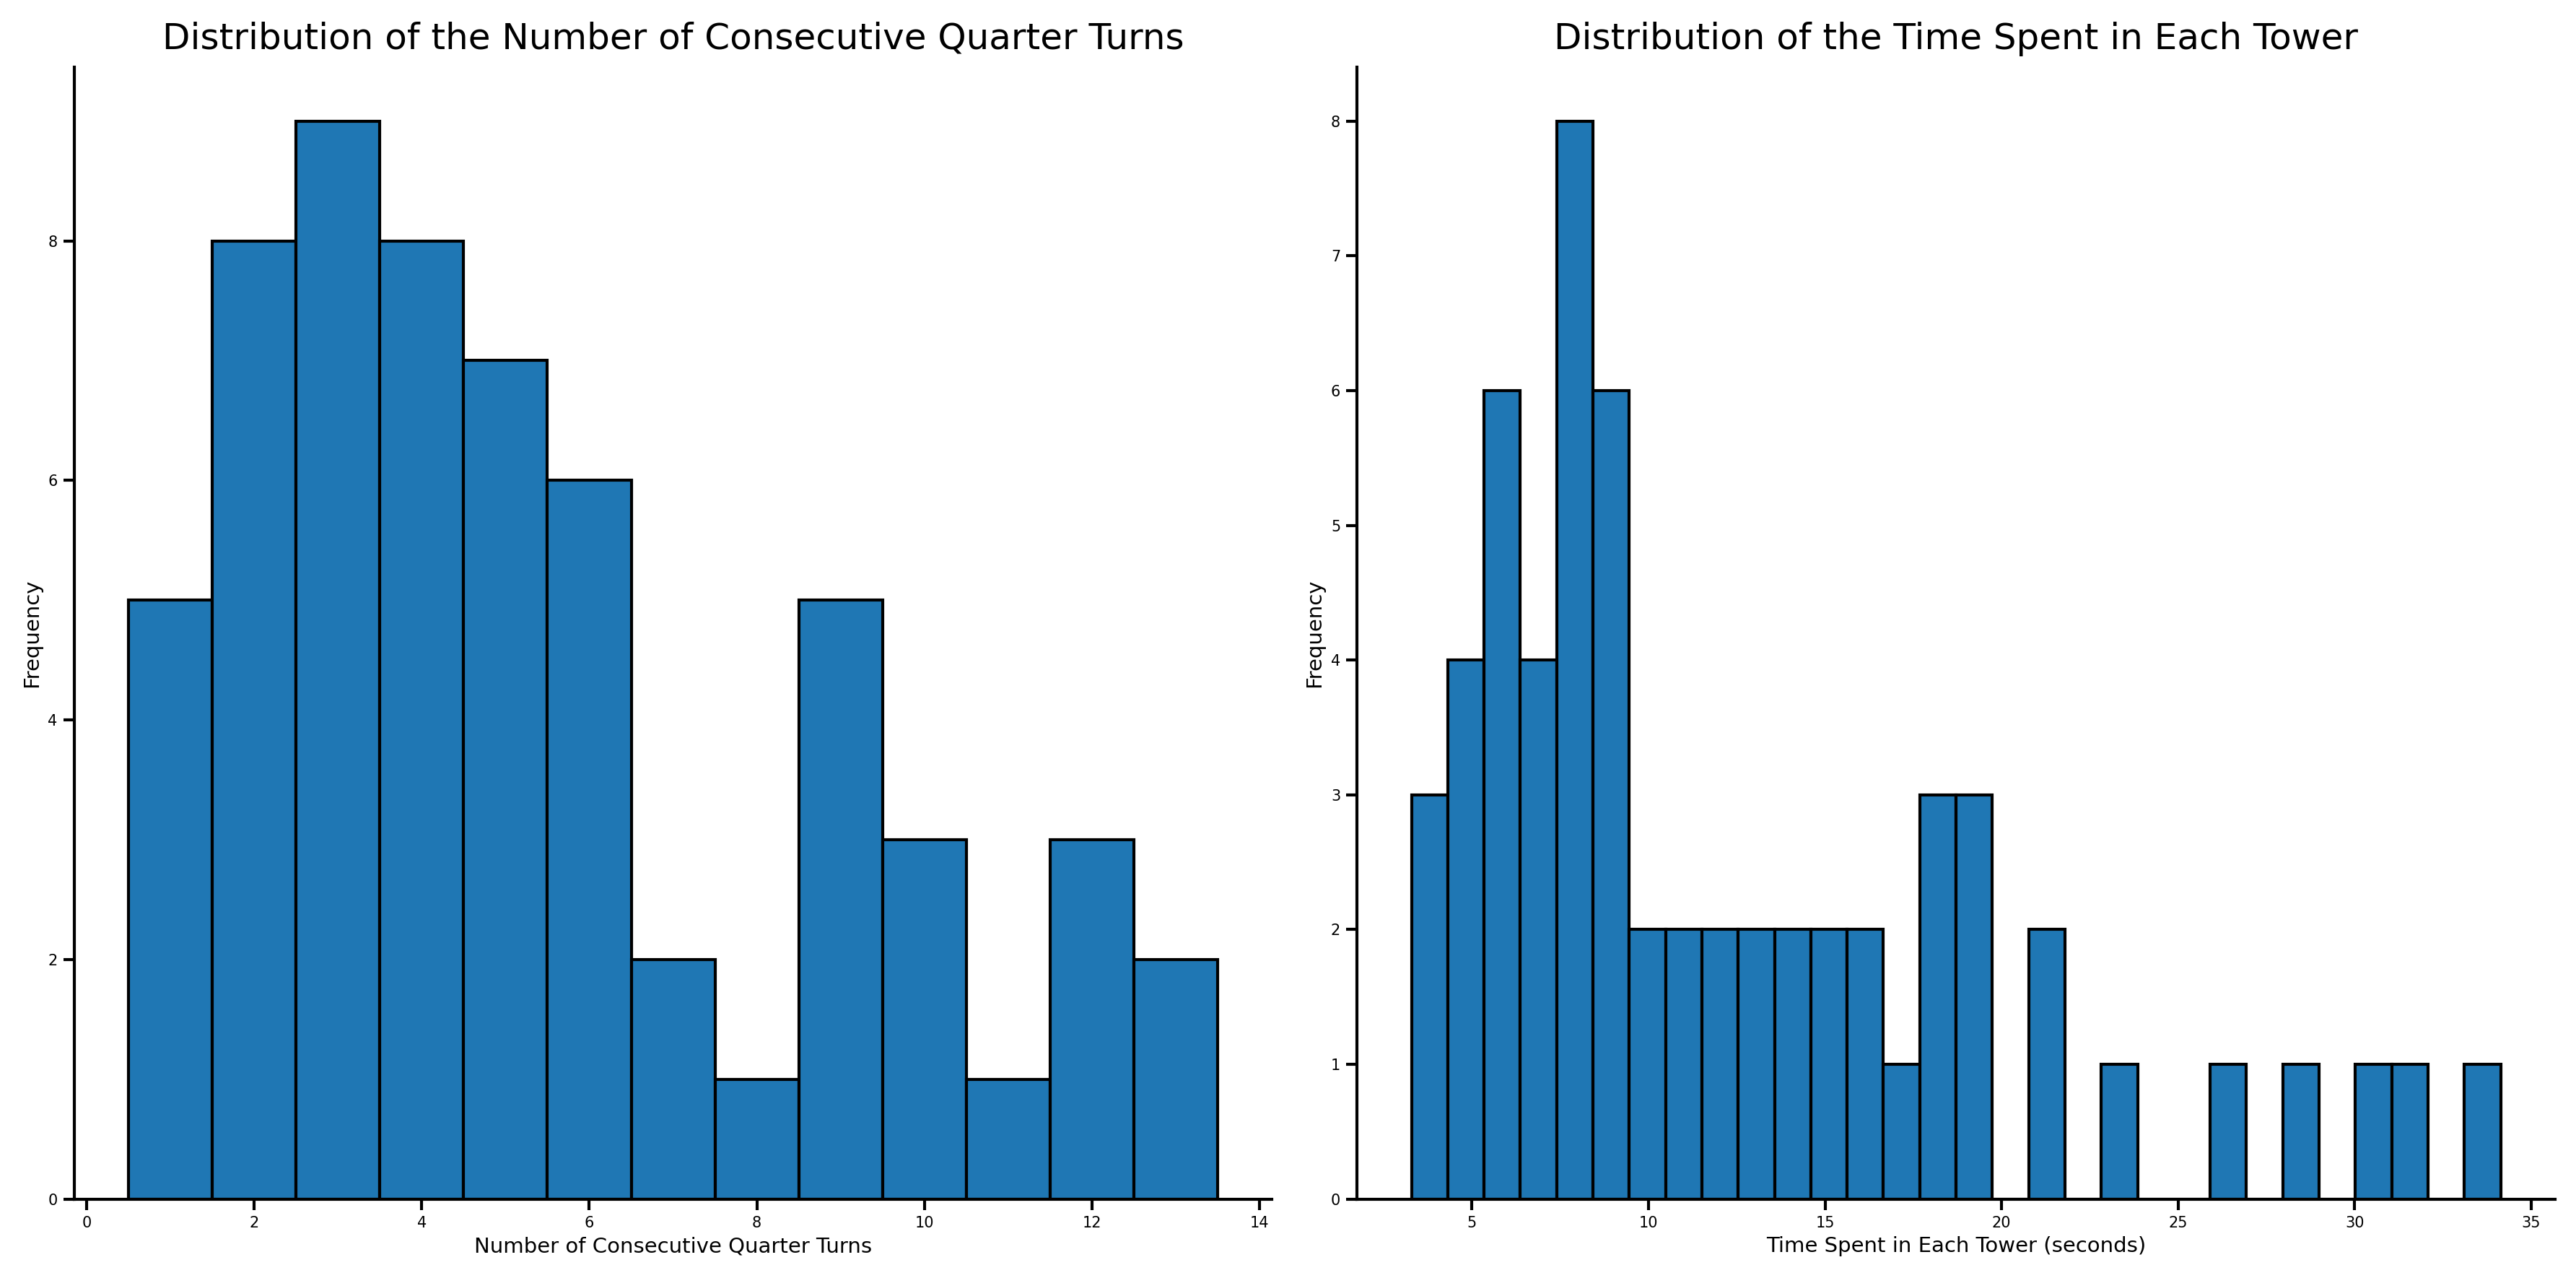

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Example usage:
consecutive_quarter_turns = plot_all_trajectories(traj_df, list_quarter_turn, turns_df, points_for_direction=4)

# Extract the number of quarter turns and the time spent for each visit
num_turns = [entry[3] for entry in consecutive_quarter_turns]
time_spent = [entry[1] - entry[0] for entry in consecutive_quarter_turns]

# Calculate the median of the number of quarter turns
median_num_turns = np.median(num_turns)
print("Median number of consecutive quarter turns per visit:", median_num_turns)

# Calculate the median time spent at each tower
median_time_spent = np.median(time_spent)
print("Median time spent at each tower (in seconds):", median_time_spent)

# Plot the distribution of the number of quarter turns
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(num_turns, bins=range(1, max(num_turns)+2), align='left', edgecolor='black')
plt.xlabel('Number of Consecutive Quarter Turns')
plt.ylabel('Frequency')
plt.title('Distribution of the Number of Consecutive Quarter Turns')

plt.subplot(1, 2, 2)
plt.hist(time_spent, bins=30, edgecolor='black')
plt.xlabel('Time Spent in Each Tower (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of the Time Spent in Each Tower')

plt.tight_layout()
plt.show()


/var/folders/m3/2hk37vnx7xbcrsllbb346xdm0000gn/T/ipykernel_41745/2604182655.py:59: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


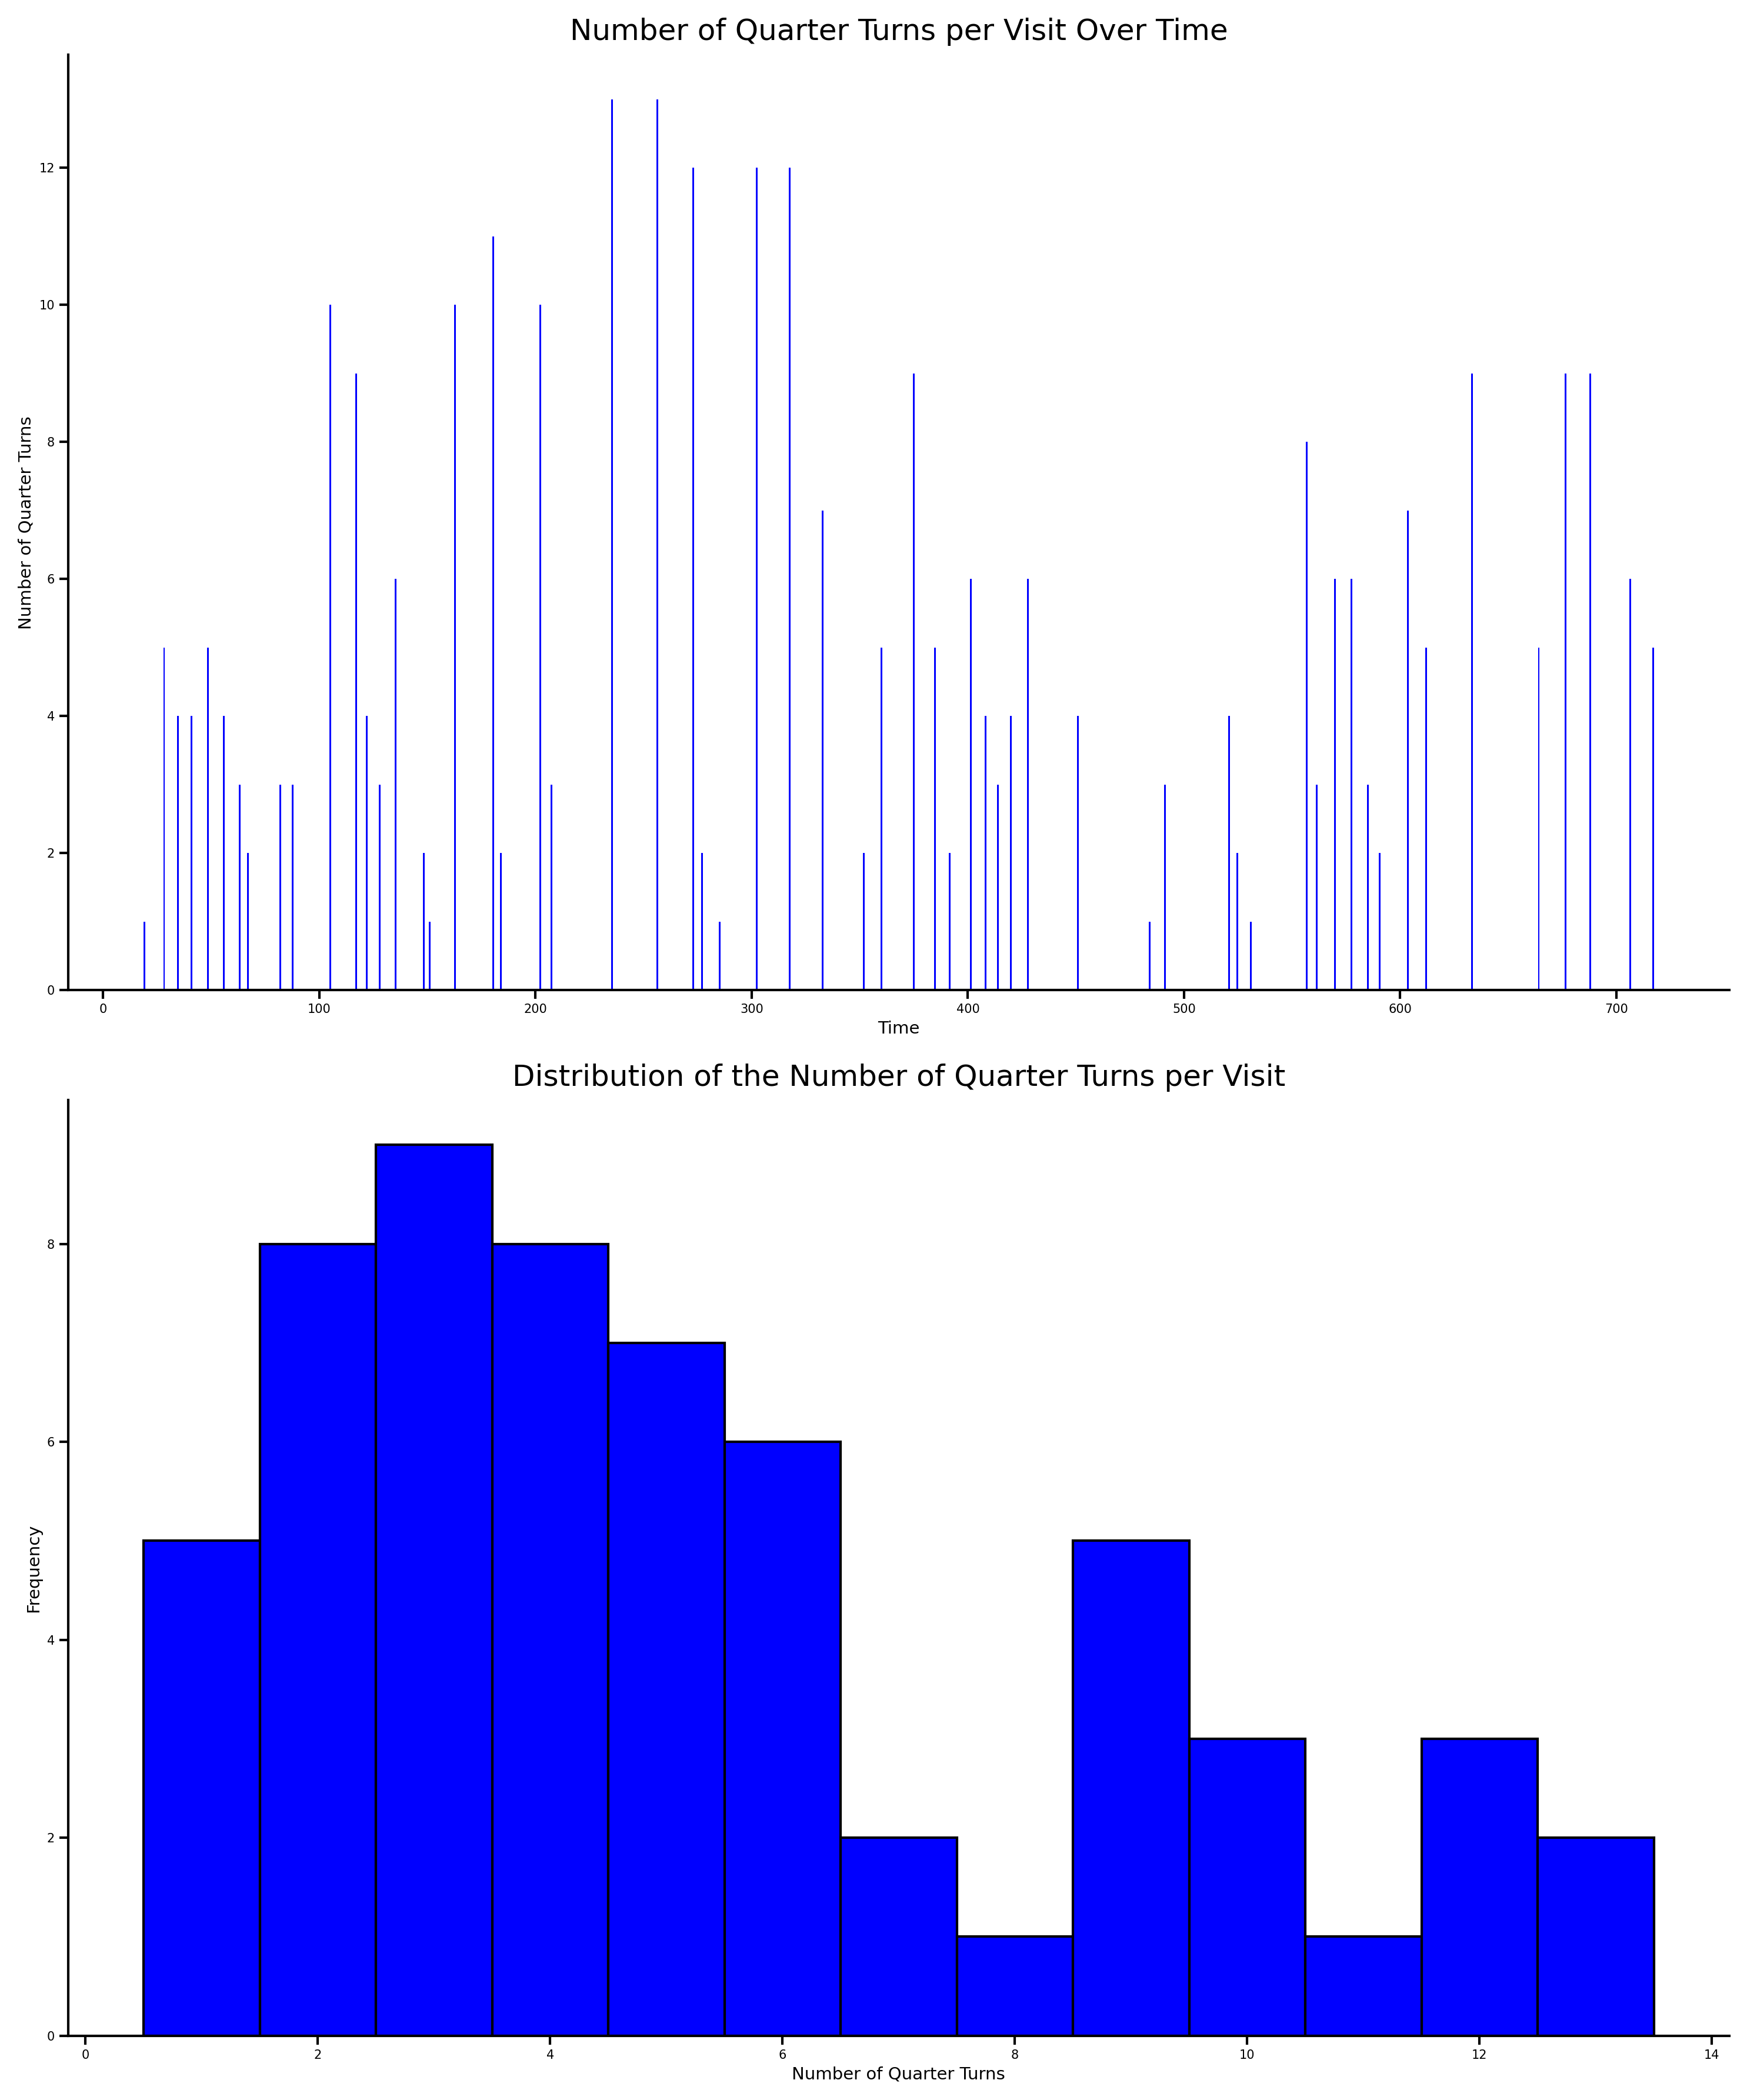

Median number of consecutive quarter turns: 4.5


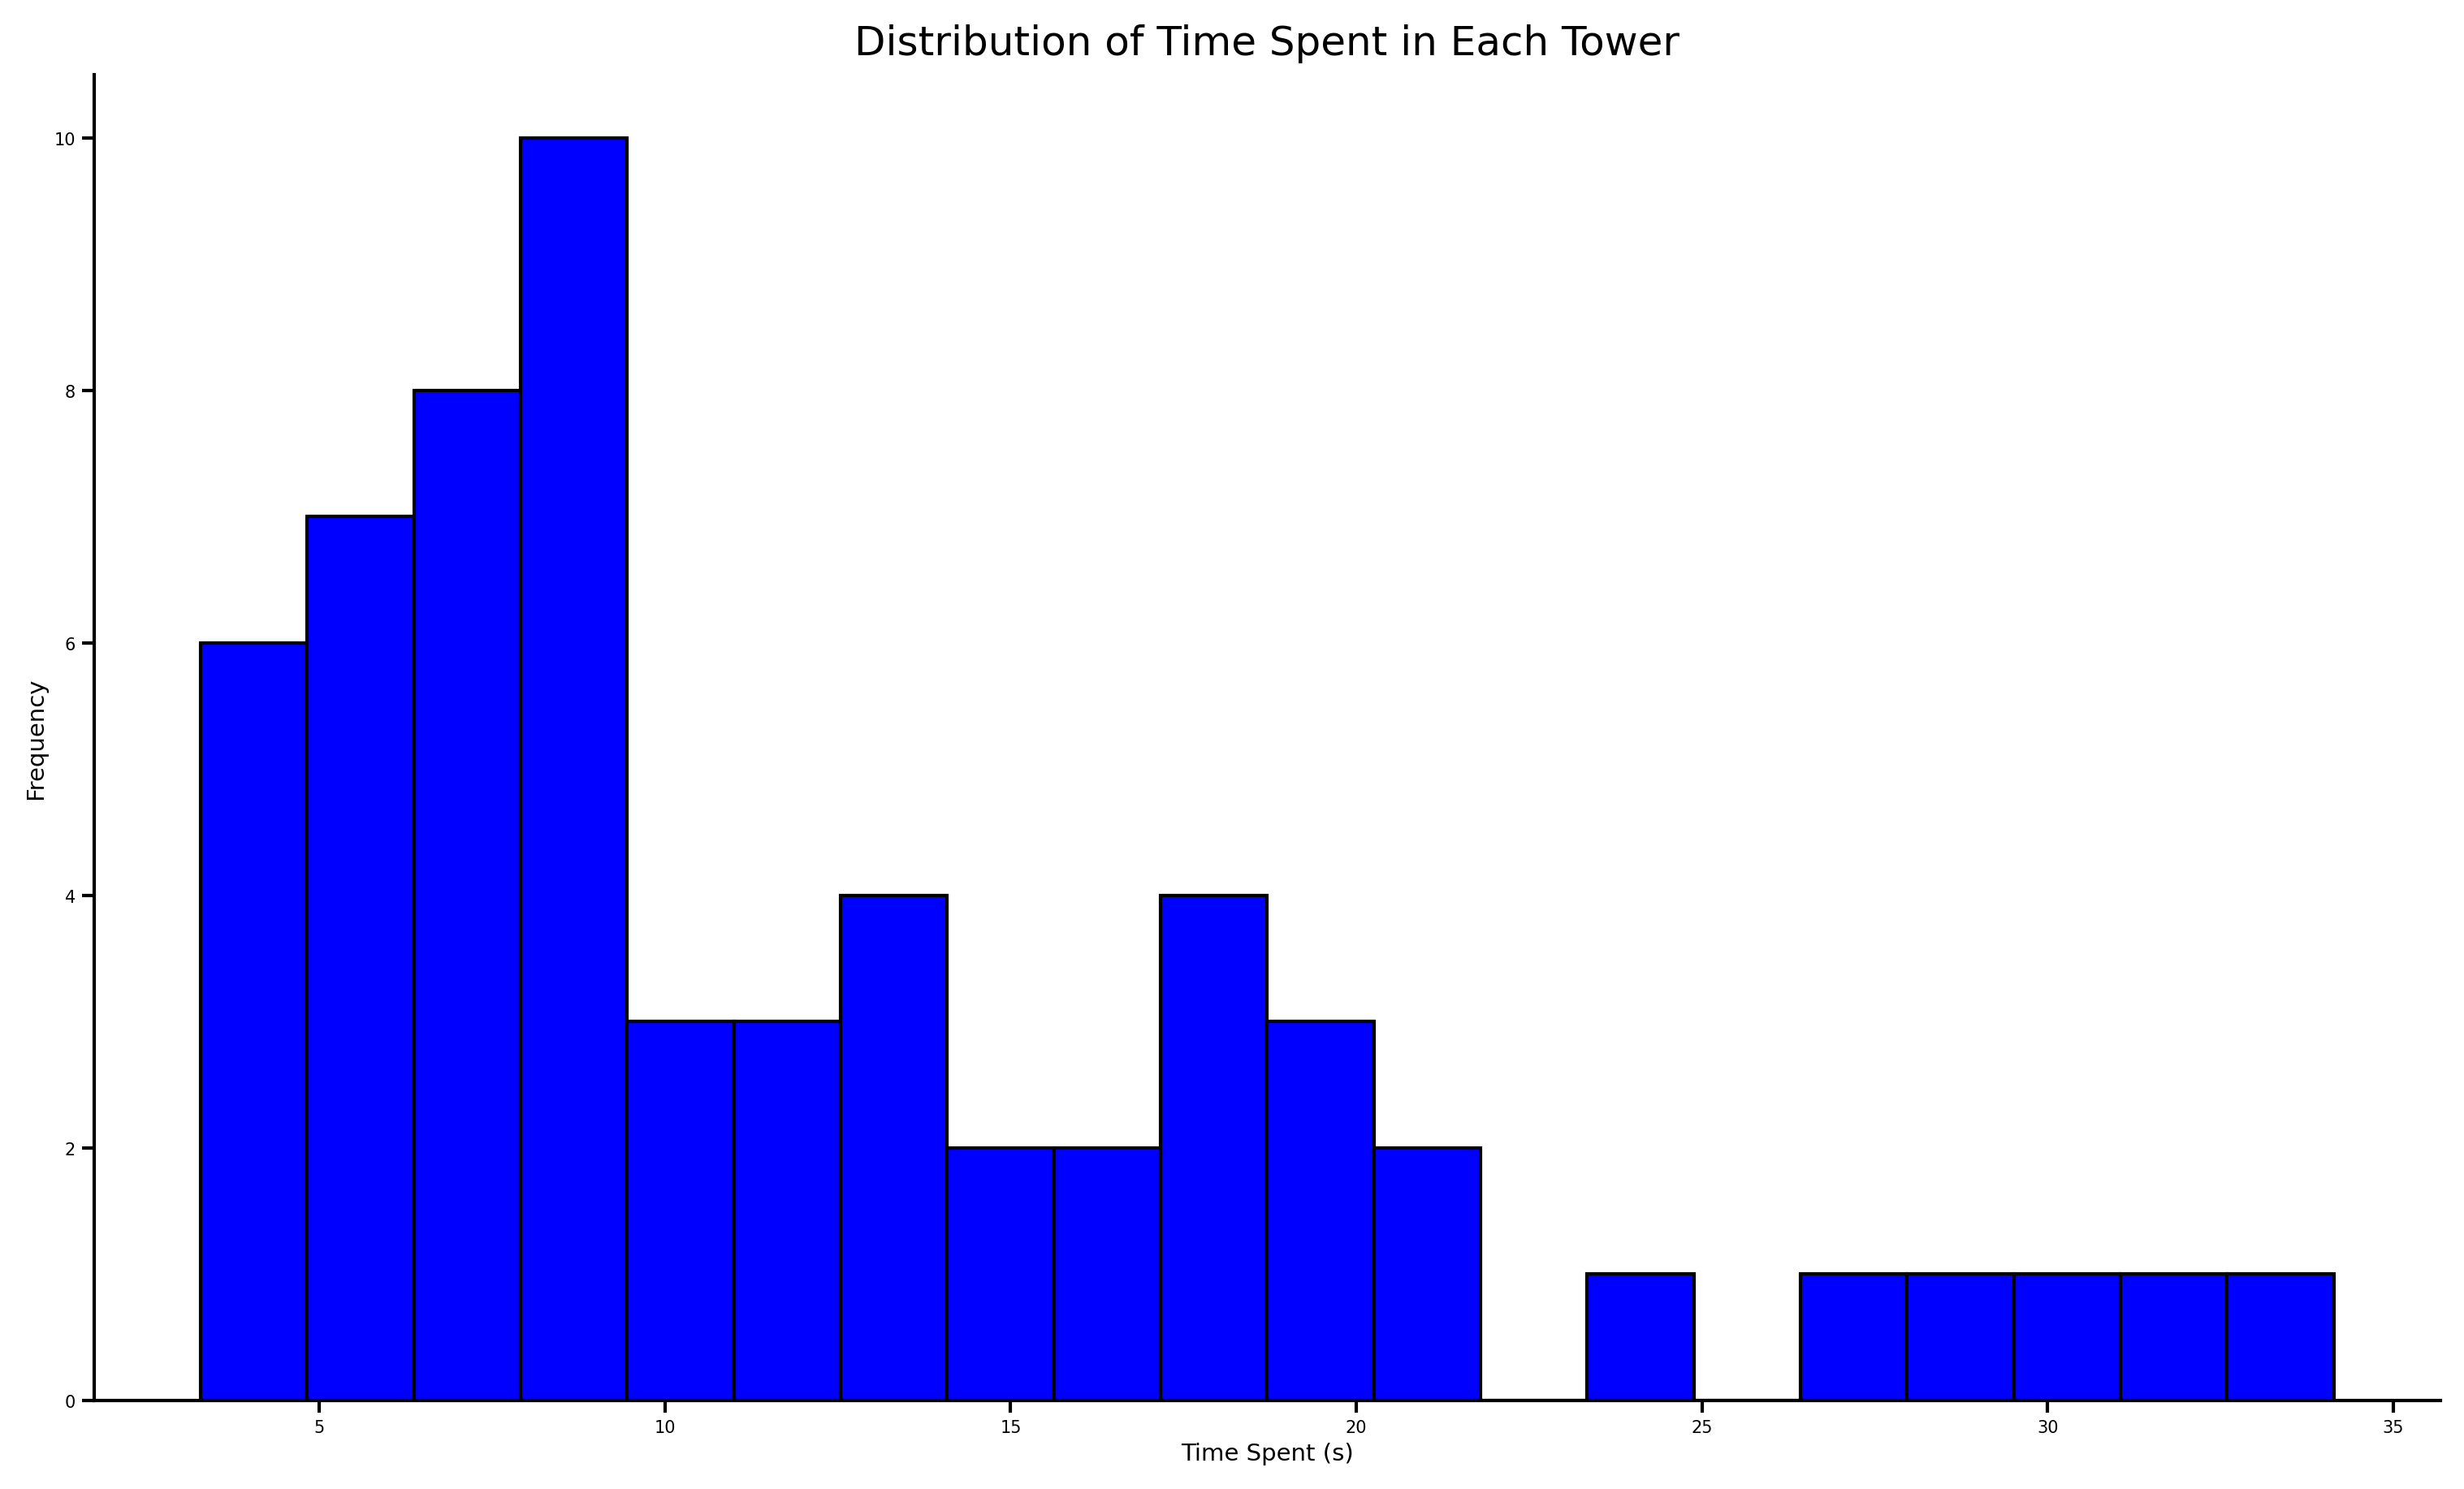

Median time spent in each tower: 9.164999999999992


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to compute consecutive quarter turns
def compute_consecutive_quarter_turns(traj_df, list_quarter_turn, turns_df):
    consecutive_quarter_turns = []
    current_tower = None
    count = 0
    start_time = None

    for idx, thisQT in enumerate(list_quarter_turn):
        start_index, end_index = thisQT[0], thisQT[1]

        if start_index < 0 or end_index >= len(traj_df):
            print(f"Indexes out of bounds for thisQT: {thisQT}")
            continue

        quarter_turn = traj_df.iloc[start_index:end_index + 1]
        
        turns_in_QT = turns_df[(turns_df['time'] >= quarter_turn['time'].iloc[0]) & (turns_df['time'] <= quarter_turn['time'].iloc[-1])]
        
        if not turns_in_QT.empty:
            current_patch = turns_in_QT.iloc[0]['currentPatch']
            if current_patch != current_tower:
                if current_tower is not None:
                    consecutive_quarter_turns.append([start_time, quarter_turn['time'].iloc[-1], current_tower, count])
                current_tower = current_patch
                start_time = quarter_turn['time'].iloc[0]
                count = 1
            else:
                count += 1

    if current_tower is not None:
        consecutive_quarter_turns.append([start_time, quarter_turn['time'].iloc[-1], current_tower, count])

    return consecutive_quarter_turns

# Example usage:
consecutive_quarter_turns = compute_consecutive_quarter_turns(traj_df, list_quarter_turn, turns_df)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot the number of quarter turns per visit over time
end_times = [entry[1] for entry in consecutive_quarter_turns]
num_turns = [entry[3] for entry in consecutive_quarter_turns]
ax1.bar(end_times, num_turns, color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Number of Quarter Turns')
ax1.set_title('Number of Quarter Turns per Visit Over Time')

# Plot the distribution of the number of quarter turns performed at each visit
ax2.hist(num_turns, bins=np.arange(1, max(num_turns)+2) - 0.5, edgecolor='black', color='blue')
ax2.set_xlabel('Number of Quarter Turns')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of the Number of Quarter Turns per Visit')

plt.tight_layout()
plt.show()

# Calculate and print the median number of consecutive quarter turns
median_consecutive_turns = np.median(num_turns)
print(f'Median number of consecutive quarter turns: {median_consecutive_turns}')

# Calculate the time spent in each tower
time_spent = [(entry[1] - entry[0]) for entry in consecutive_quarter_turns]

# Plot the distribution of time spent in each tower
plt.figure(figsize=(10, 6))
plt.hist(time_spent, bins=20, edgecolor='black', color='blue')
plt.xlabel('Time Spent (s)')
plt.ylabel('Frequency')
plt.title('Distribution of Time Spent in Each Tower')
plt.show()

# Calculate and print the median time spent in each tower
median_time_spent = np.median(time_spent)
print(f'Median time spent in each tower: {median_time_spent}')


In [57]:
consecutive_quarter_turns

[[np.float64(15.034), np.float64(19.074), 'SW', 1],
 [np.float64(18.355), np.float64(28.163), 'NW', 5],
 [np.float64(27.482), np.float64(34.567), 'NE', 4],
 [np.float64(34.045), np.float64(40.808), 'SE', 4],
 [np.float64(40.168), np.float64(48.412), 'SW', 5],
 [np.float64(47.451), np.float64(55.776), 'NW', 4],
 [np.float64(55.216), np.float64(63.099), 'NE', 3],
 [np.float64(62.461), np.float64(66.902), 'NW', 2],
 [np.float64(66.302), np.float64(81.831), 'SW', 3],
 [np.float64(81.351), np.float64(87.595), 'SE', 3],
 [np.float64(87.073), np.float64(105.082), 'NW', 10],
 [np.float64(104.361), np.float64(117.129), 'SW', 9],
 [np.float64(116.529), np.float64(122.012), 'SE', 4],
 [np.float64(121.532), np.float64(127.775), 'NE', 3],
 [np.float64(127.135), np.float64(135.219), 'SE', 6],
 [np.float64(134.578), np.float64(148.345), 'SW', 2],
 [np.float64(147.743), np.float64(151.027), 'NW', 1],
 [np.float64(150.426), np.float64(162.834), 'NE', 10],
 [np.float64(162.273), np.float64(180.445), 'SE

In [53]:
import pickle

picklefiletoupload = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/MOU2334/MOU2334_20240620-1516/Pickle_data/consecutive_quarter_turns.pkl'

# Open the pickle file in read-binary mode
with open(picklefiletoupload, 'rb') as file:
    consecutive_quarter_turns = pickle.load(file)

# Print the unpickled data
print(consecutive_quarter_turns)

[[np.float64(15.25), np.float64(15.25), 1], [np.float64(16.211), np.float64(16.211), 1], [np.float64(17.051), np.float64(17.051), 1], [np.float64(17.892), np.float64(17.892), 1], [np.float64(18.813), np.float64(18.813), 1], [np.float64(19.653), np.float64(20.532), 3], [np.float64(22.974), np.float64(22.974), 1], [np.float64(24.653), np.float64(24.653), 1], [np.float64(25.575), np.float64(25.575), 1], [np.float64(26.377), np.float64(26.377), 1], [np.float64(27.095), np.float64(27.095), 1], [np.float64(27.777), np.float64(27.777), 1], [np.float64(29.815), np.float64(29.815), 1], [np.float64(32.259), np.float64(32.259), 1], [np.float64(38.582), np.float64(38.582), 1], [np.float64(40.582), np.float64(40.582), 1], [np.float64(41.464), np.float64(41.464), 1], [np.float64(42.665), np.float64(42.665), 1], [np.float64(43.704), np.float64(43.704), 1], [np.float64(44.745), np.float64(44.745), 1], [np.float64(45.667), np.float64(45.667), 1], [np.float64(46.707), np.float64(46.707), 1], [np.float64

Median number of consecutive quarter turns per visit: 4.5
Median time spent at each tower (in seconds): 9.164999999999992


/var/folders/m3/2hk37vnx7xbcrsllbb346xdm0000gn/T/ipykernel_41745/3653886582.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


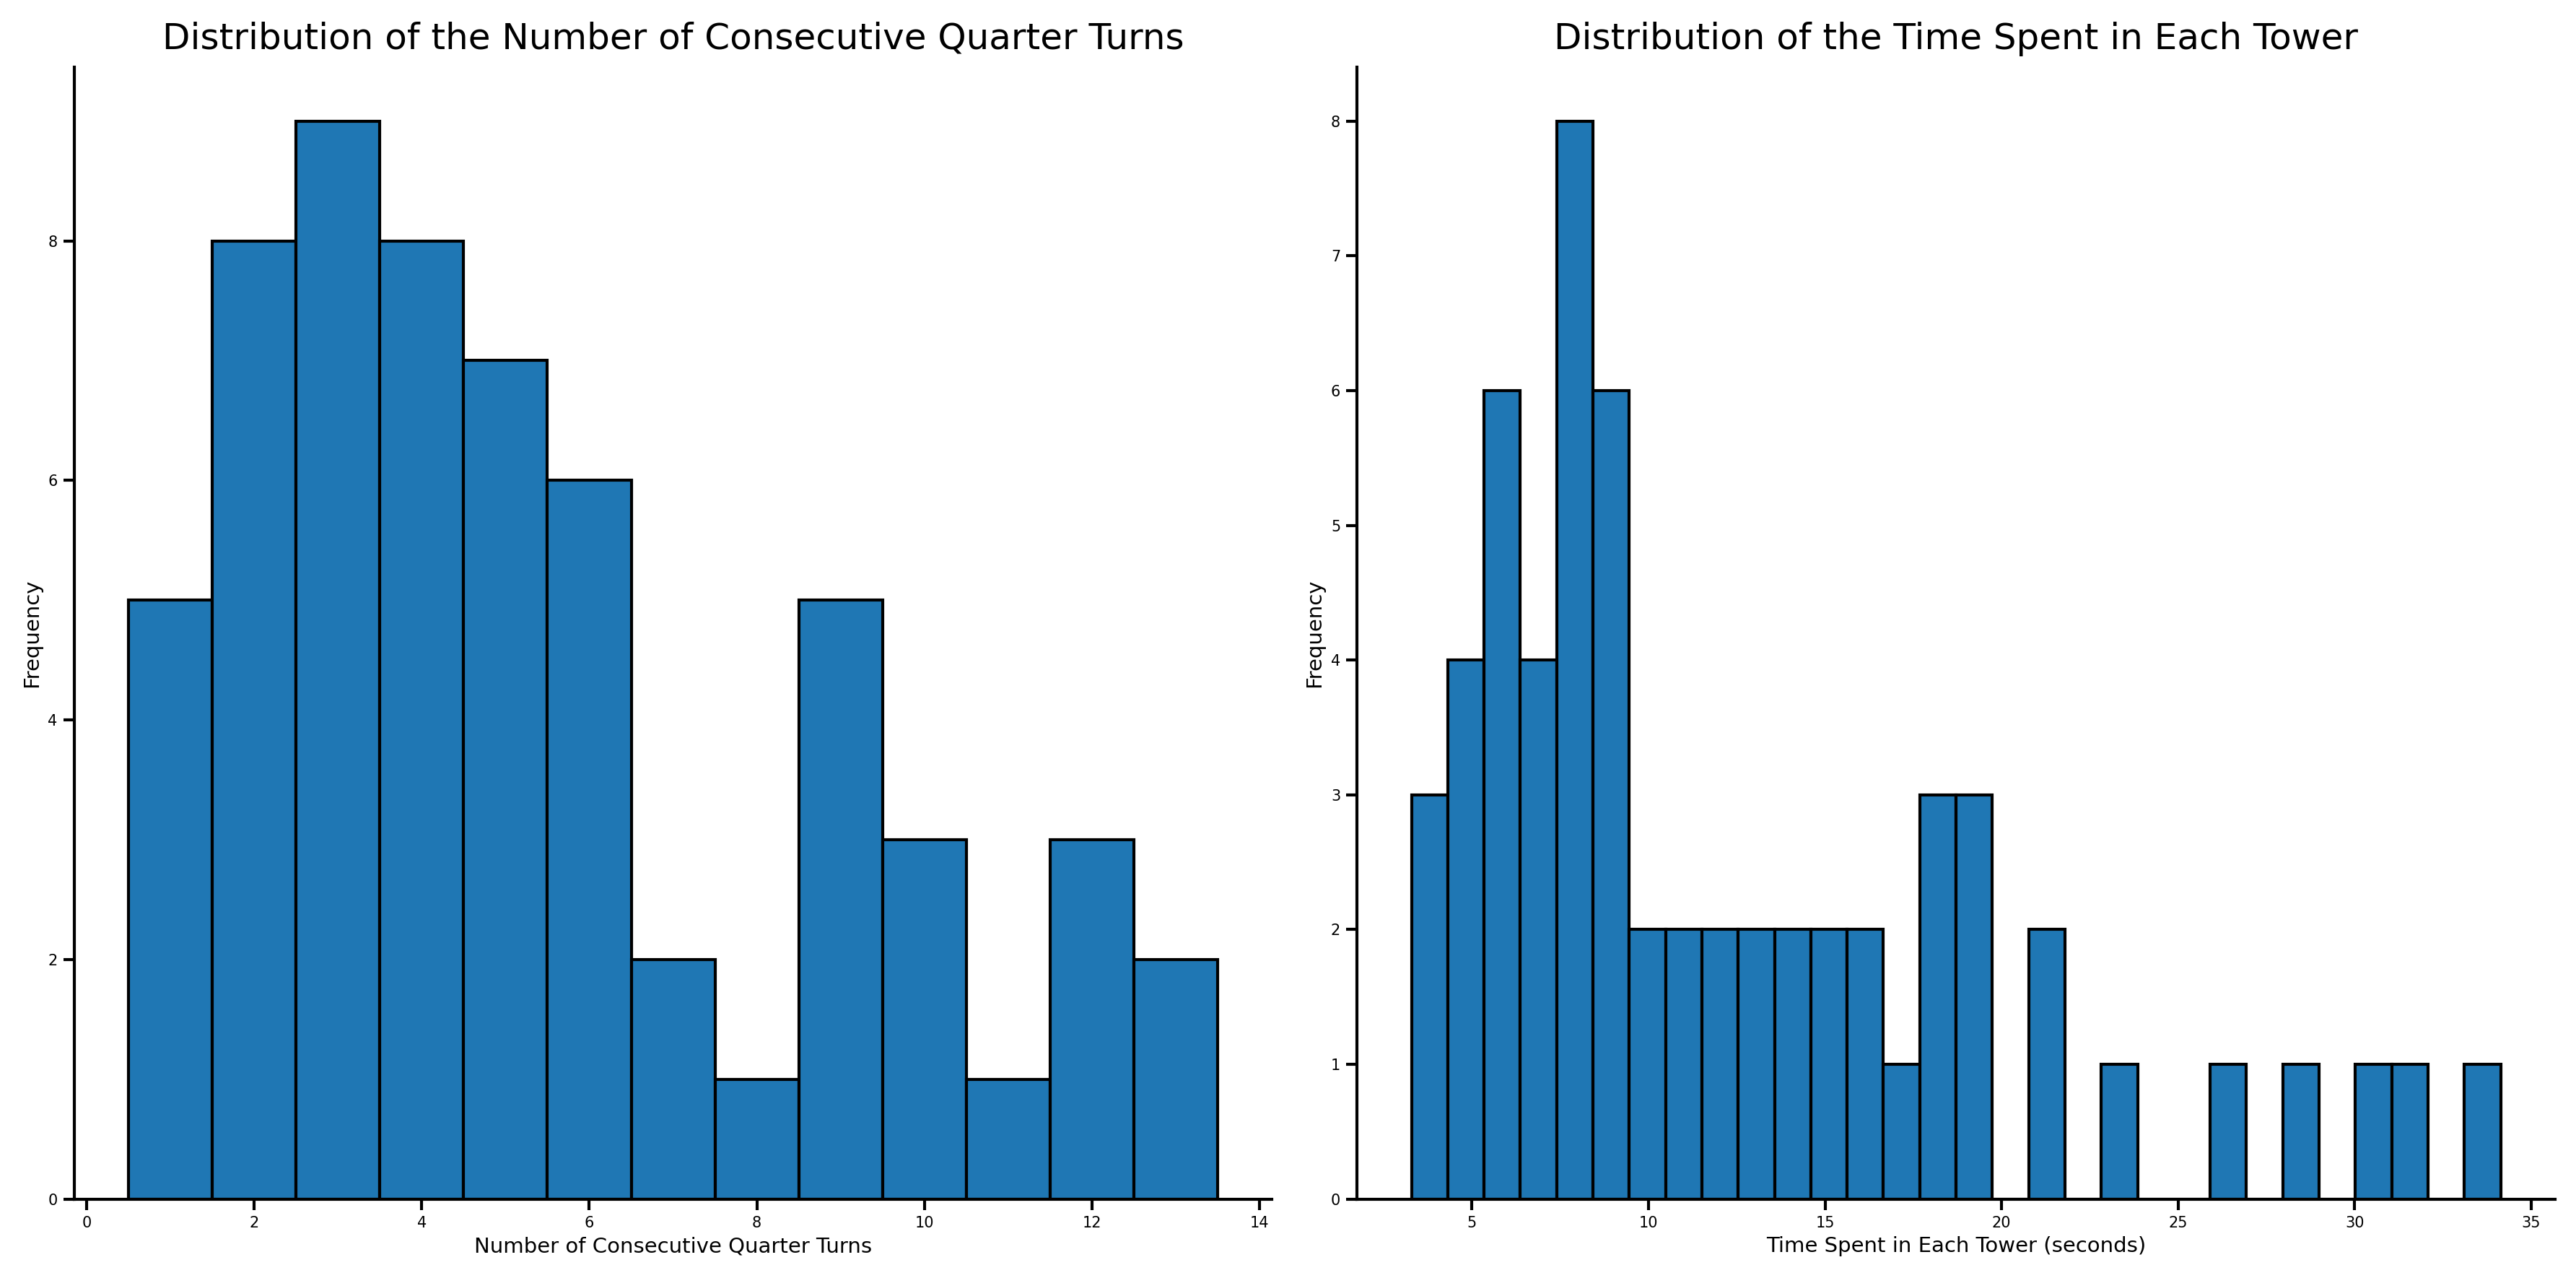

In [62]:
# Extract the number of quarter turns and the time spent for each visit
num_turns = [entry[3] for entry in consecutive_quarter_turns]
time_spent = [entry[1] - entry[0] for entry in consecutive_quarter_turns]

# Calculate the median of the number of quarter turns
median_num_turns = np.median(num_turns)
print("Median number of consecutive quarter turns per visit:", median_num_turns)

# Calculate the median time spent at each tower
median_time_spent = np.median(time_spent)
print("Median time spent at each tower (in seconds):", median_time_spent)

# Plot the distribution of the number of quarter turns
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(num_turns, bins=range(1, max(num_turns)+2), align='left', edgecolor='black')
plt.xlabel('Number of Consecutive Quarter Turns')
plt.ylabel('Frequency')
plt.title('Distribution of the Number of Consecutive Quarter Turns')

plt.subplot(1, 2, 2)
plt.hist(time_spent, bins=30, edgecolor='black')
plt.xlabel('Time Spent in Each Tower (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of the Time Spent in Each Tower')

plt.tight_layout()
plt.show()

In [ ]:
import pickle

picklefiletoupload = '/Users/davidrobbe/Documents/Science/Data/ForagingMice/MOU4175/MOU4175_20230712-1809/Pickle_data/consecutive_quarter_turns.pkl'

# Open the pickle file in read-binary mode
with open(picklefiletoupload, 'rb') as file:
    consecutive_quarter_turns = pickle.load(file)

# Print the unpickled data
print(consecutive_quarter_turns)


In [ ]:
for movement_type, title, _axs in zip(movement_types, titles, _axs):
            figure_trajectories(traj_df, movement_type, xgauss, ygauss, speed, angular_speed, acceleration, title, axs=_axs)


In [ ]:
# function original function to visulalize the dffierent types of movements.
def figure_trajectories(traj_df, current_movement, xgauss, ygauss, speed, angular_speed, acceleration, title='', axs=None):
    if axs is None:
        _, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(5, 15))
    else:
        ax1, ax2, ax3, ax4 = axs

    for patch in collection_trapeze:  # plot the trapeze around the object
        for trapeze in collection_trapeze[patch]:
            shape = Polygon(np.array(collection_trapeze[patch][trapeze]), color="lemonchiffon")
            ax1.add_patch(shape)
        for u in current_movement:  # plot each individual trajectory of the current category
            colors = plt.cm.rainbow(np.random.random())
            if len(u) != 0:
                ax1.plot(xgauss[u[0]:u[1]], ygauss[u[0]:u[1]], lw=0.5, c=colors)
            else:
                pass

    # Plots a colored dot at the begining and end of each epoch
    indices_start = [u[0] for u in current_movement]
    indices_end = [u[1] for u in current_movement]
    if len(indices_start) != 0 or len(indices_end) != 0:
        ax1.scatter(xgauss[indices_start], ygauss[indices_start], linewidths=0.1, color="green")
        ax1.scatter(xgauss[indices_end], ygauss[indices_end], linewidths= 0.1, color="red")
    else:
        pass

    timeSpentIn = round(sum([traj_df.loc[traj_df.index[epoch[1]], 'time'] - traj_df.loc[traj_df.index[epoch[0]], 'time'] for epoch in current_movement]), 2)

    # Sets the parameters of the graph
    ax1.set_ylim(0, 500)
    ax1.set_xlim(0, 500)
    ax1.set_title(title + str(len(current_movement)) + f"\n total time: {timeSpentIn}s")
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)


    # Gets the speed and angular speed depending on the category
    speedy = []
    angle_speedy = []
    accelery = []
    for u in current_movement:
        for i in range(u[0], u[1] + 1):
            speedy += [speed[i]]
            angle_speedy += [angular_speed[i]]
            accelery += [acceleration[i]]

    ################## 
    # Plots the speed for the type of trajectory
    if len(speedy)!= 0:
        ax2.hist(speedy, bins=np.arange(0, 100, 1), density=True)
    else:
        ax2.hist([0], bins=np.arange(0, 100, 1), density=True)
    ax2.set_xlabel("Speed (cm/s)")
    ax2.set_ylim(0, 0.06)
    ax2.axvline(TRUE_CUT_SPEED, c='red', lw=0.5)

    ######################
    # Plots the angular speed for the type of trajectory
    if len(angle_speedy)!= 0:
        ax3.hist(angle_speedy, bins=np.arange(-50, 50, .5), density=True)
    else :
        ax3.hist([0], bins=np.arange(-50, 50, .5), density=True)
    ax3.set_xlabel("Angular speed (degree/s)")
    ax3.text(-50, 0.02, "CW", ha='left')
    ax3.text(50, 0.02, "CCW", ha='right')
    ax3.set_ylim(0, 0.15)
    ax3.axvline(15, c='red', lw=0.5)
    ax3.axvline(-15, c='red', lw=0.5)
    ax3.axvline(0, c='k', lw=0.5)

    # Plots the acceleration for the type of trajectory
    if len(accelery)!= 0:
        ax4.hist(accelery, bins=np.arange(-25, 25, 0.3), density=True)
    else:
        ax4.hist([0], bins=np.arange(-25, 25, 0.3), density=True)
    ax4.set_xlabel('Acceleration (cm.s-2)')
    ax4.set_ylim(0, 0.16)

In [ ]:
# original function to visulalize the dffierent types of movements.
def figure_trajectories(traj_df, current_movement, xgauss, ygauss, speed, angular_speed, acceleration, title='', axs=None):
    if axs is None:
        _, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(5, 15))
    else:
        ax1, ax2, ax3, ax4 = axs

    for patch in collection_trapeze:  # plot the trapeze around the object
        for trapeze in collection_trapeze[patch]:
            shape = Polygon(np.array(collection_trapeze[patch][trapeze]), color="lemonchiffon")
            ax1.add_patch(shape)
        for u in current_movement:  # plot each individual trajectory of the current category
            colors = plt.cm.rainbow(np.random.random())
            if len(u) != 0:
                ax1.plot(xgauss[u[0]:u[1]], ygauss[u[0]:u[1]], lw=0.5, c=colors)
            else:
                pass

    # Plots a colored dot at the begining and end of each epoch
    indices_start = [u[0] for u in current_movement]
    indices_end = [u[1] for u in current_movement]
    if len(indices_start) != 0 or len(indices_end) != 0:
        ax1.scatter(xgauss[indices_start], ygauss[indices_start], linewidths=0.1, color="green")
        ax1.scatter(xgauss[indices_end], ygauss[indices_end], linewidths= 0.1, color="red")
    else:
        pass

    timeSpentIn = round(sum([traj_df.loc[traj_df.index[epoch[1]], 'time'] - traj_df.loc[traj_df.index[epoch[0]], 'time'] for epoch in current_movement]), 2)

    # Sets the parameters of the graph
    ax1.set_ylim(0, 500)
    ax1.set_xlim(0, 500)
    ax1.set_title(title + str(len(current_movement)) + f"\n total time: {timeSpentIn}s")
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)


    # Gets the speed and angular speed depending on the category
    speedy = []
    angle_speedy = []
    accelery = []
    for u in current_movement:
        for i in range(u[0], u[1] + 1):
            speedy += [speed[i]]
            angle_speedy += [angular_speed[i]]
            accelery += [acceleration[i]]

    ################## 
    # Plots the speed for the type of trajectory
    if len(speedy)!= 0:
        ax2.hist(speedy, bins=np.arange(0, 100, 1), density=True)
    else:
        ax2.hist([0], bins=np.arange(0, 100, 1), density=True)
    ax2.set_xlabel("Speed (cm/s)")
    ax2.set_ylim(0, 0.06)
    ax2.axvline(TRUE_CUT_SPEED, c='red', lw=0.5)

    ######################
    # Plots the angular speed for the type of trajectory
    if len(angle_speedy)!= 0:
        ax3.hist(angle_speedy, bins=np.arange(-50, 50, .5), density=True)
    else :
        ax3.hist([0], bins=np.arange(-50, 50, .5), density=True)
    ax3.set_xlabel("Angular speed (degree/s)")
    ax3.text(-50, 0.02, "CW", ha='left')
    ax3.text(50, 0.02, "CCW", ha='right')
    ax3.set_ylim(0, 0.15)
    ax3.axvline(15, c='red', lw=0.5)
    ax3.axvline(-15, c='red', lw=0.5)
    ax3.axvline(0, c='k', lw=0.5)

    # Plots the acceleration for the type of trajectory
    if len(accelery)!= 0:
        ax4.hist(accelery, bins=np.arange(-25, 25, 0.3), density=True)
    else:
        ax4.hist([0], bins=np.arange(-25, 25, 0.3), density=True)
    ax4.set_xlabel('Acceleration (cm.s-2)')
    ax4.set_ylim(0, 0.16)